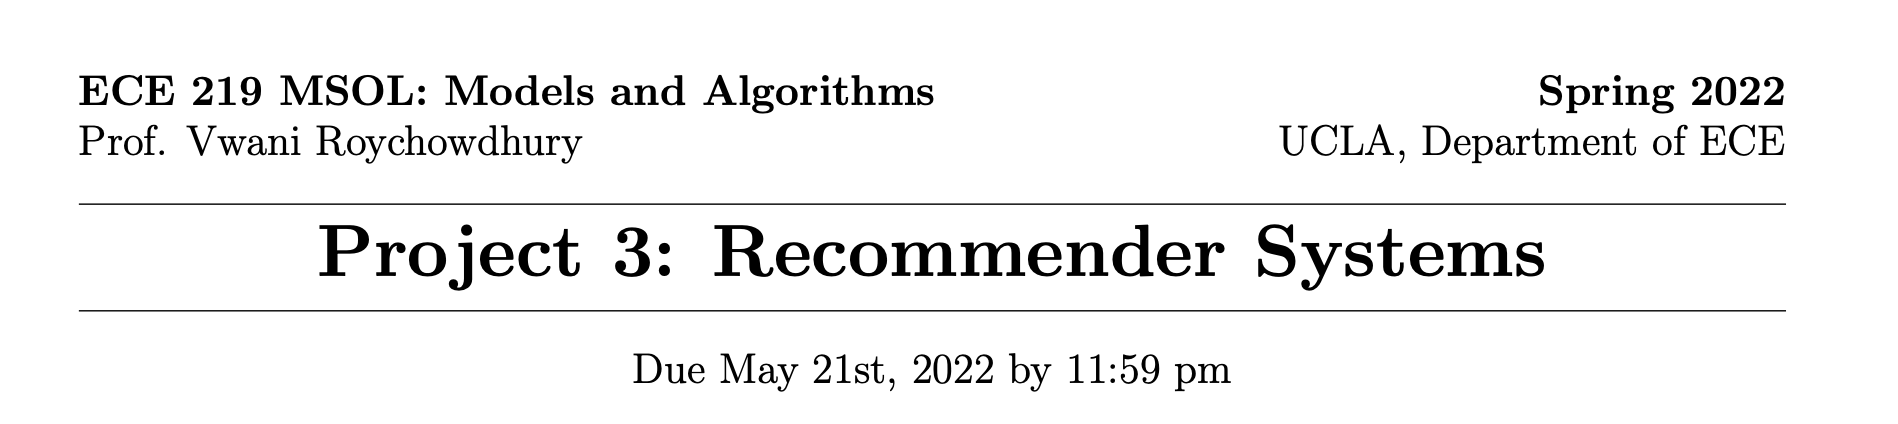

In [ ]:
pip install surprise

In [ ]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

PATH = 'drive/MyDrive/ECE219/Project3/'

os.chdir(PATH)

Mounted at /content/drive


## Helper Functions

In [ ]:
def popular_movie_trimming(testdata, pivot_table):
  frequency_movies = np.sum(pivot_table!=0, axis=0)
  frequency_movies = dict(filter(lambda x: x[1] > 2, frequency_movies.items()))
  testdata = list(filter(lambda x: x[1] in frequency_movies.keys(), testdata))
  return testdata

def unpopular_movie_trimming(testdata, pivot_table):
  frequency_movies = np.sum(pivot_table!=0, axis=0)
  frequency_movies = dict(filter(lambda x: x[1] <= 2, frequency_movies.items()))
  testdata = list(filter(lambda x: x[1] in frequency_movies.keys(), testdata))
  return testdata

def high_variance_trimming(testdata, pivot_table):
  var_movies = np.var(pivot_table, axis = 0)
  frequency_movies = np.sum(pivot_table!=0, axis=0)
  frequency_movies = dict(filter(lambda x: x[1]>=5, frequency_movies.items()))
  var_movies = dict(filter(lambda x: x[1]>=2.0, var_movies.items()))
  testdata = list(filter(lambda x: (x[1] in frequency_movies.keys()), testdata))
  testdata = list(filter(lambda x: (x[1] in var_movies.keys()), testdata))
  return testdata

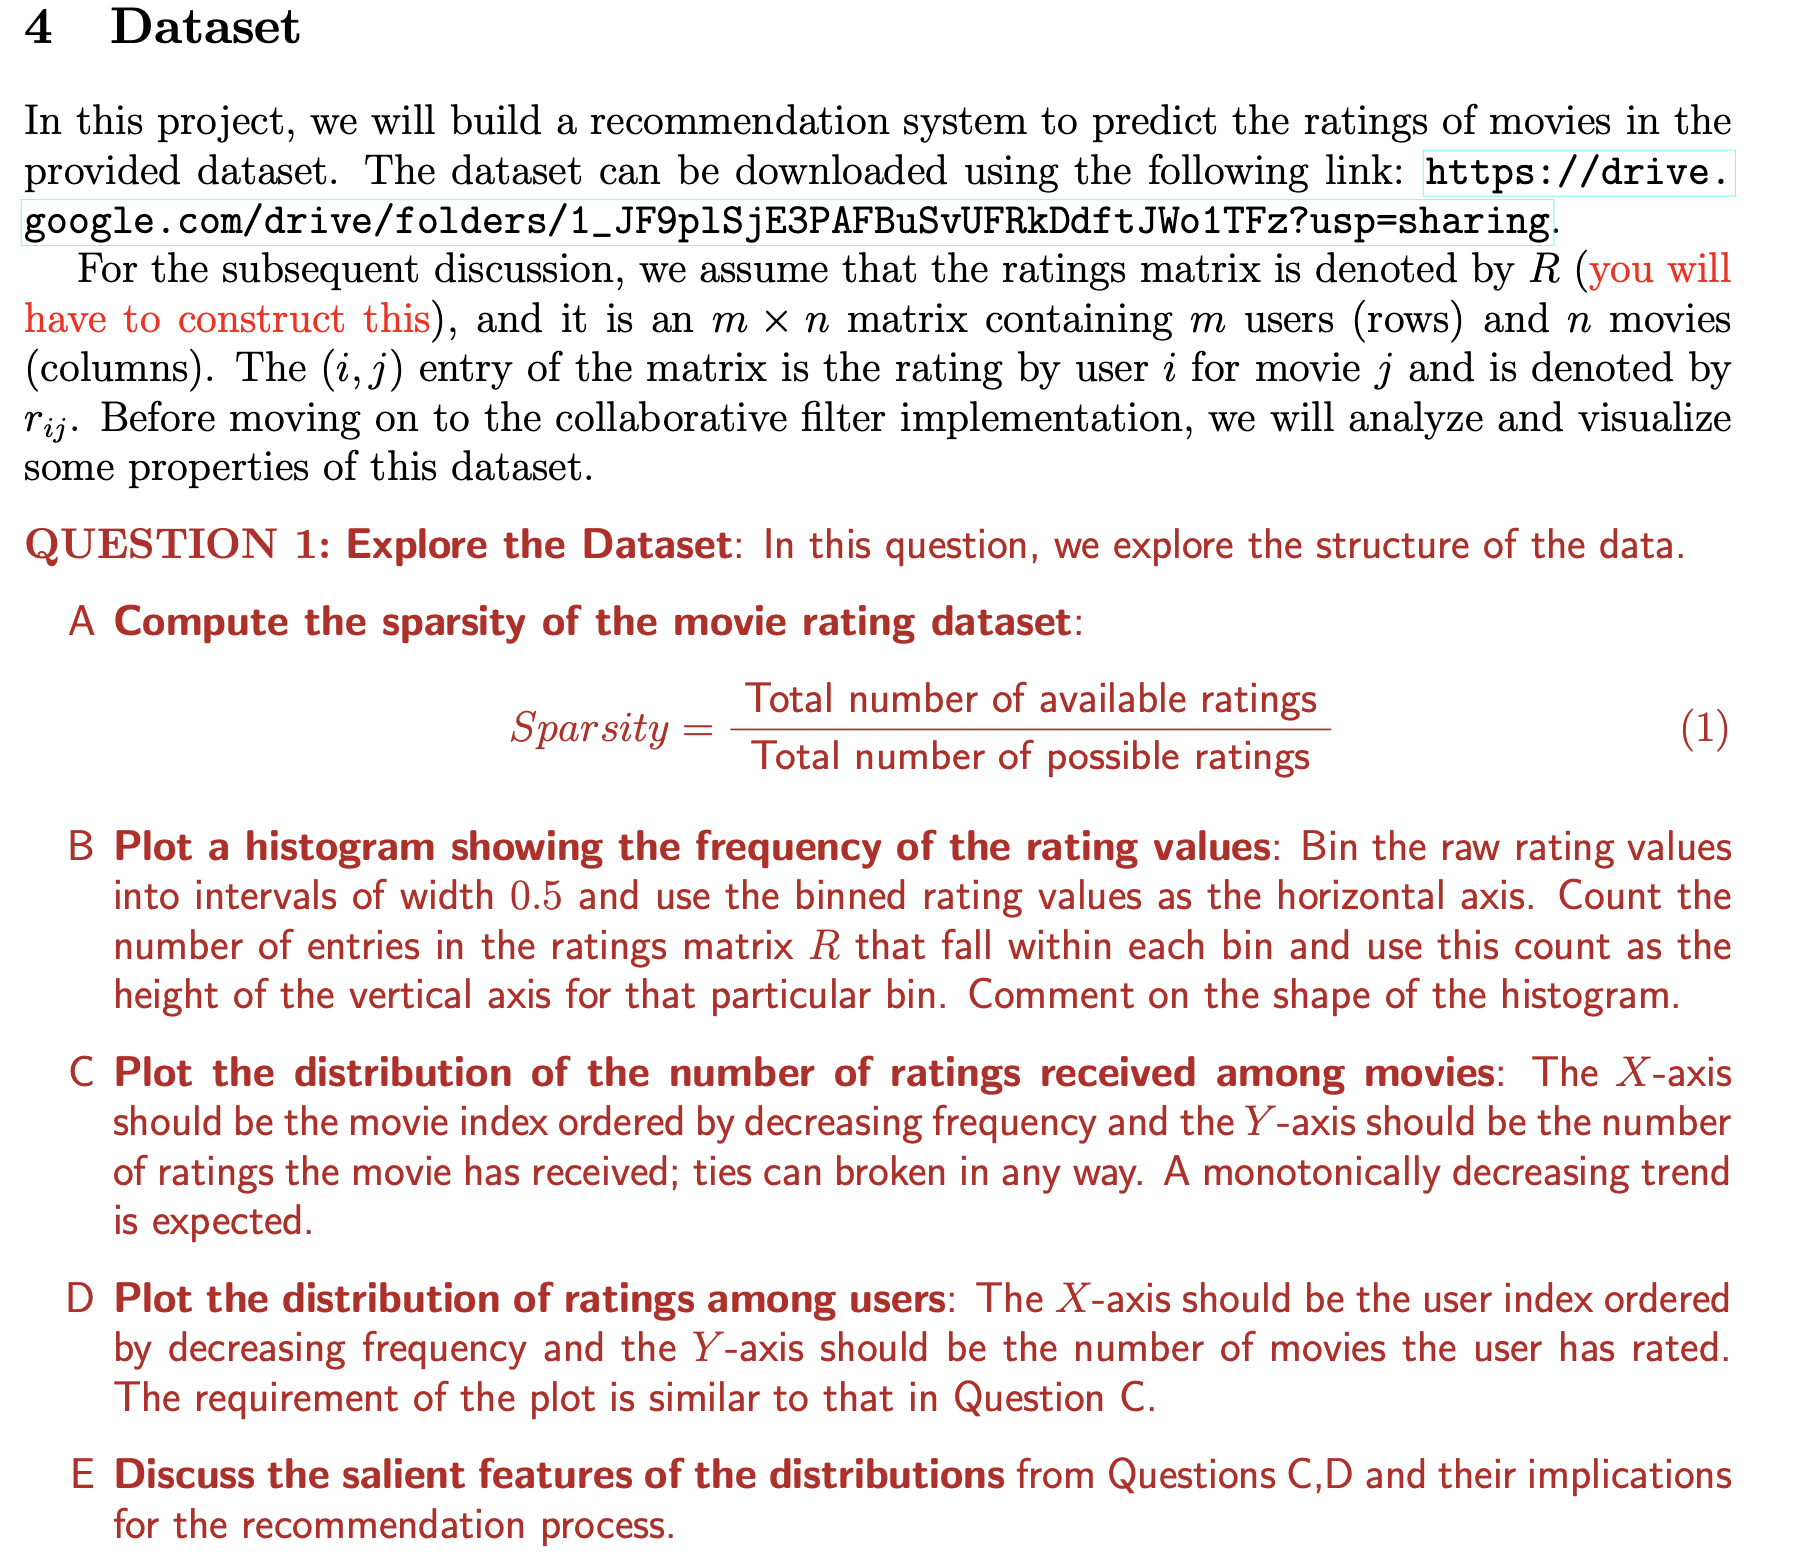

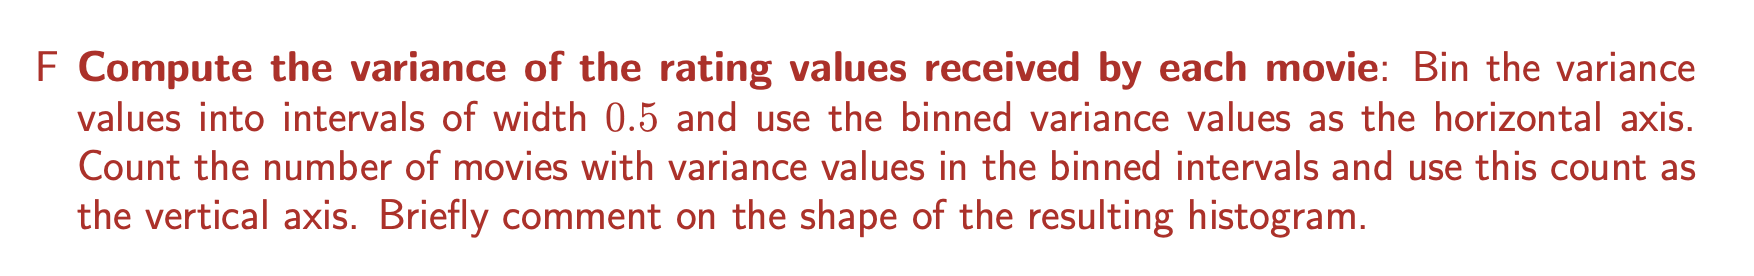

## Reading in the Data

In [ ]:
df_links = pd.read_csv('Synthetic_Movie_Lens/links.csv')
df_links.head()

movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0

In [ ]:
df_movies = pd.read_csv('Synthetic_Movie_Lens/movies.csv')
df_movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [ ]:
df_ratings = pd.read_csv('Synthetic_Movie_Lens/ratings.csv')
df_ratings.head()

Unnamed: 0  userId  movieId  rating   timestamp
0           0     496   112852     3.0  1415520462
1           1     391     1947     4.0  1030945141
2           2     387     1562     1.5  1095041022
3           3     474     2716     4.5  1053020930
4           4     483    88125     4.5  1311337237

In [ ]:
df_tags = pd.read_csv('Synthetic_Movie_Lens/tags.csv')
df_tags.head()

userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774              MMA  1445715200

## Constructing a Ratings Matrix

In [ ]:
ratings = df_ratings.pivot_table('rating', 'userId', 'movieId', fill_value=0)
ratings.head()

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     0.0     4.0     0.0     0.0     4.5     0.0       0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0       0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0       0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0       0   
5           4.0     0.0     0.0     0.0     0.0     0.0     0.0       0   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                   
1           0.0     0.0  ...     0.0       0       0       0     0.0       0   
2           0.0     0.0  ...     0.0       0       0       0     0.0       0   
3           0.0     0.0  ...     0.0       0       0       0     0.0       0   
4           0.0     0.0  ...     0.0       0       0       0     0.0       0   
5           0.0     0.0  ...     0.0       0       0       0     0.0       0   

movieId  193583  193585  193587  193609  
userId                                   
1           0.0     0.0     0.0       0  
2           0.0     0.0     0.0       0  
3           0.0     0.0     0.0       0  
4           0.0     0.0     0.0       0  
5           0.0     0.0     0.0       0  

[5 rows x 9724 columns]

In [ ]:
total_avail_ratings = len(df_ratings)
total_possible_ratings = np.prod(ratings.shape)
sparsity = total_avail_ratings/total_possible_ratings
sparsity

0.016999683055613623

In [ ]:
np.min(df_ratings.rating)

0.5

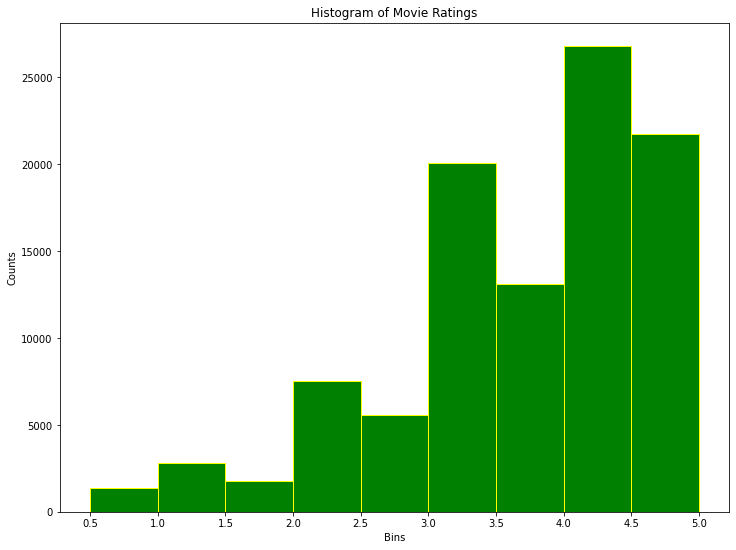

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
plt.hist(df_ratings.rating, bins=9, edgecolor="yellow", color="green")
ax.set_xlabel('Bins')
ax.set_ylabel('Counts')
ax.set_xticks(np.unique(df_ratings.rating))
ax.set_title('Histogram of Movie Ratings')
plt.show()

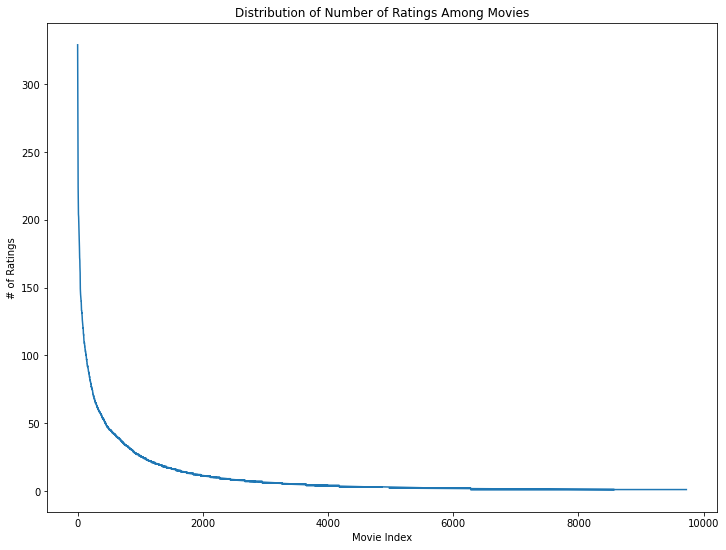

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
plt.plot(np.argsort(df_ratings.movieId.value_counts()), np.sort(df_ratings.movieId.value_counts()))
ax.set_xlabel('Movie Index')
ax.set_ylabel('# of Ratings')
ax.set_title('Distribution of Number of Ratings Among Movies')
plt.show()

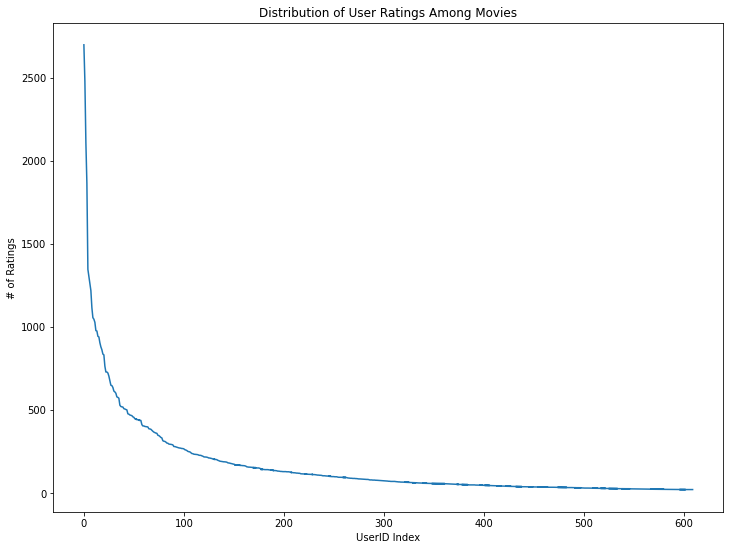

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
plt.plot(np.argsort(df_ratings.userId.value_counts()), np.sort(df_ratings.userId.value_counts()))
ax.set_xlabel('UserID Index')
ax.set_ylabel('# of Ratings')
ax.set_title('Distribution of User Ratings Among Movies')
plt.show()

In [ ]:
hist_df = df_ratings.groupby(df_ratings.movieId).var().fillna(0)
hist_df.rating
bins = np.linspace(0,5,num=11)

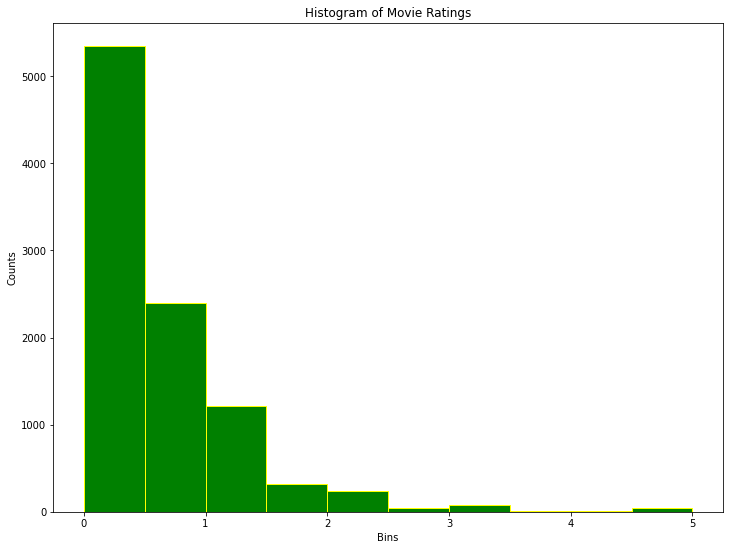

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
plt.hist(hist_df.rating, bins=bins, edgecolor="yellow", color="green")
ax.set_xlabel('Bins')
ax.set_ylabel('Counts')
ax.set_title('Histogram of Movie Ratings')
plt.show()

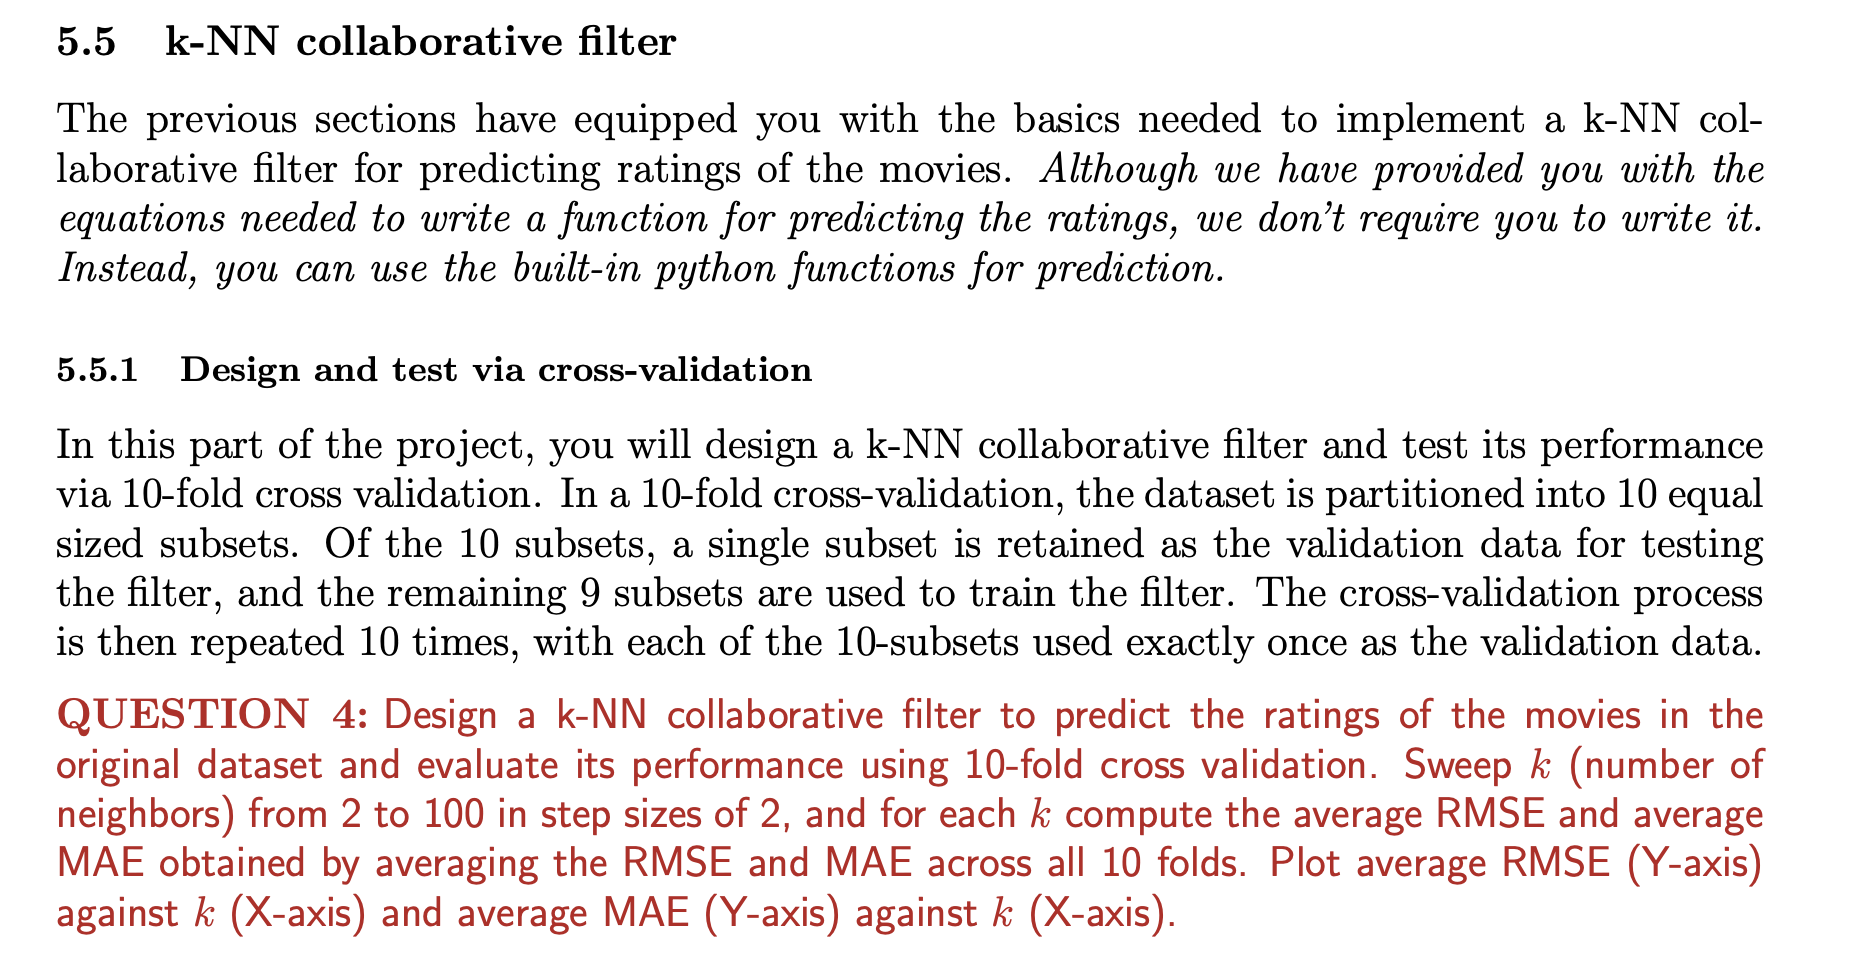

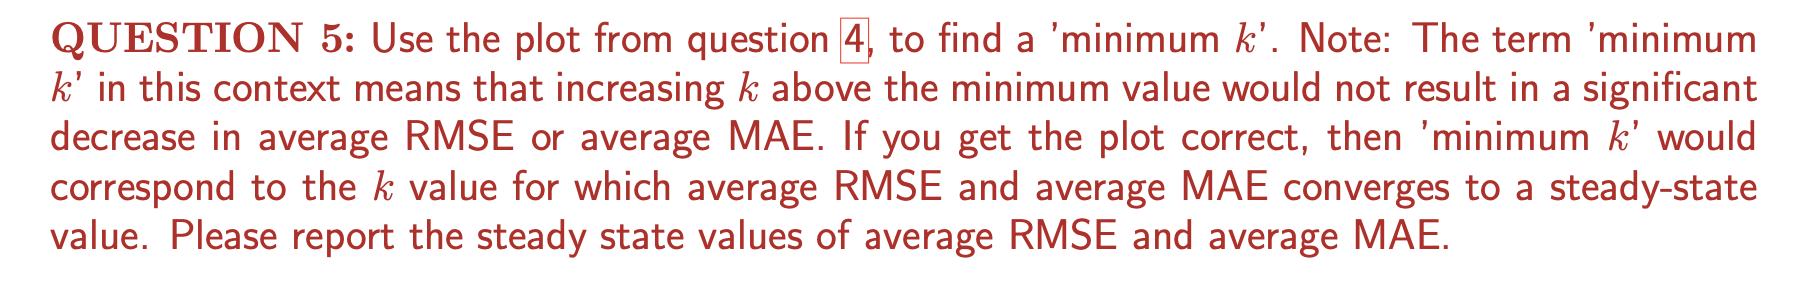

In [ ]:
df_ratings.columns

Index(['Unnamed: 0', 'userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [ ]:
%%capture 

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import KNNWithMeans

RMSE = []
MAE = []
knn_k_vals = np.arange(2,102,2)
                
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(.5, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)

for k in range(2,102,2):
    knn = KNNWithMeans(k=k, sim_options = {'name': 'pearson'})
    cv = cross_validate(knn, data, measures=['RMSE','MAE'], cv=10, verbose=False)
    RMSE.append(np.mean(cv['test_rmse']))
    MAE.append(np.mean(cv['test_mae']))

KeyboardInterrupt: ignored

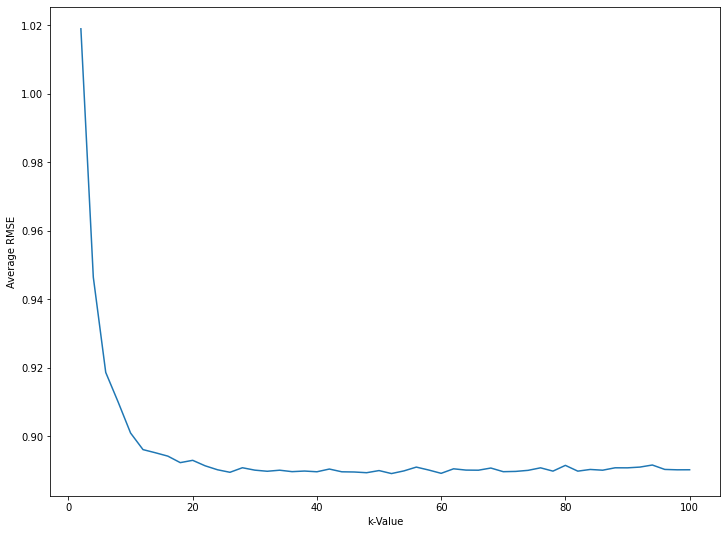

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
plt.plot(knn_k_vals, RMSE)
ax.set_xlabel('k-Value')
ax.set_ylabel('Average RMSE')
ax.set_title('')
plt.show()

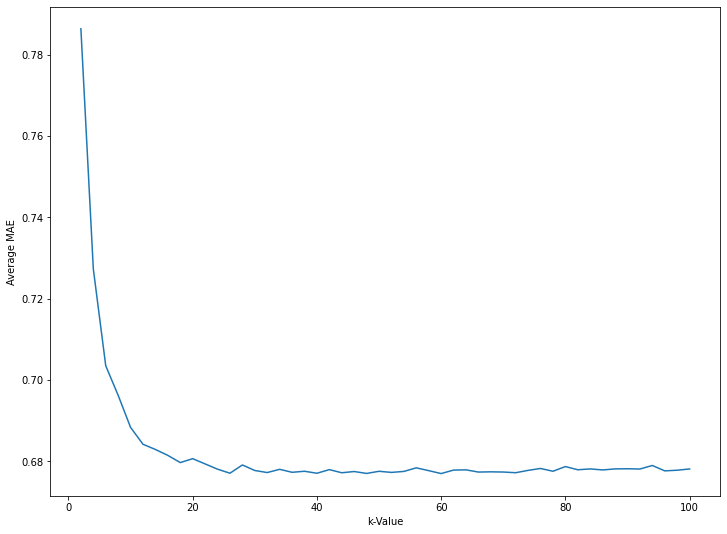

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
plt.plot(knn_k_vals, MAE)
ax.set_xlabel('k-Value')
ax.set_ylabel('Average MAE')
ax.set_title('')
plt.show()

In [ ]:
for k in range(1, len(RMSE) + 1):
  if (abs(RMSE[k]-RMSE[k+1]) < 0.0001):
    min_k = k * 2
    print("Minimum k:", min_k)
    print("RMSE Value:", RMSE[k])
    print("MAE Value:", MAE[k])
    break;

Minimum k: 42
RMSE Value: 0.8895514513622688
MAE Value: 0.677153432319215


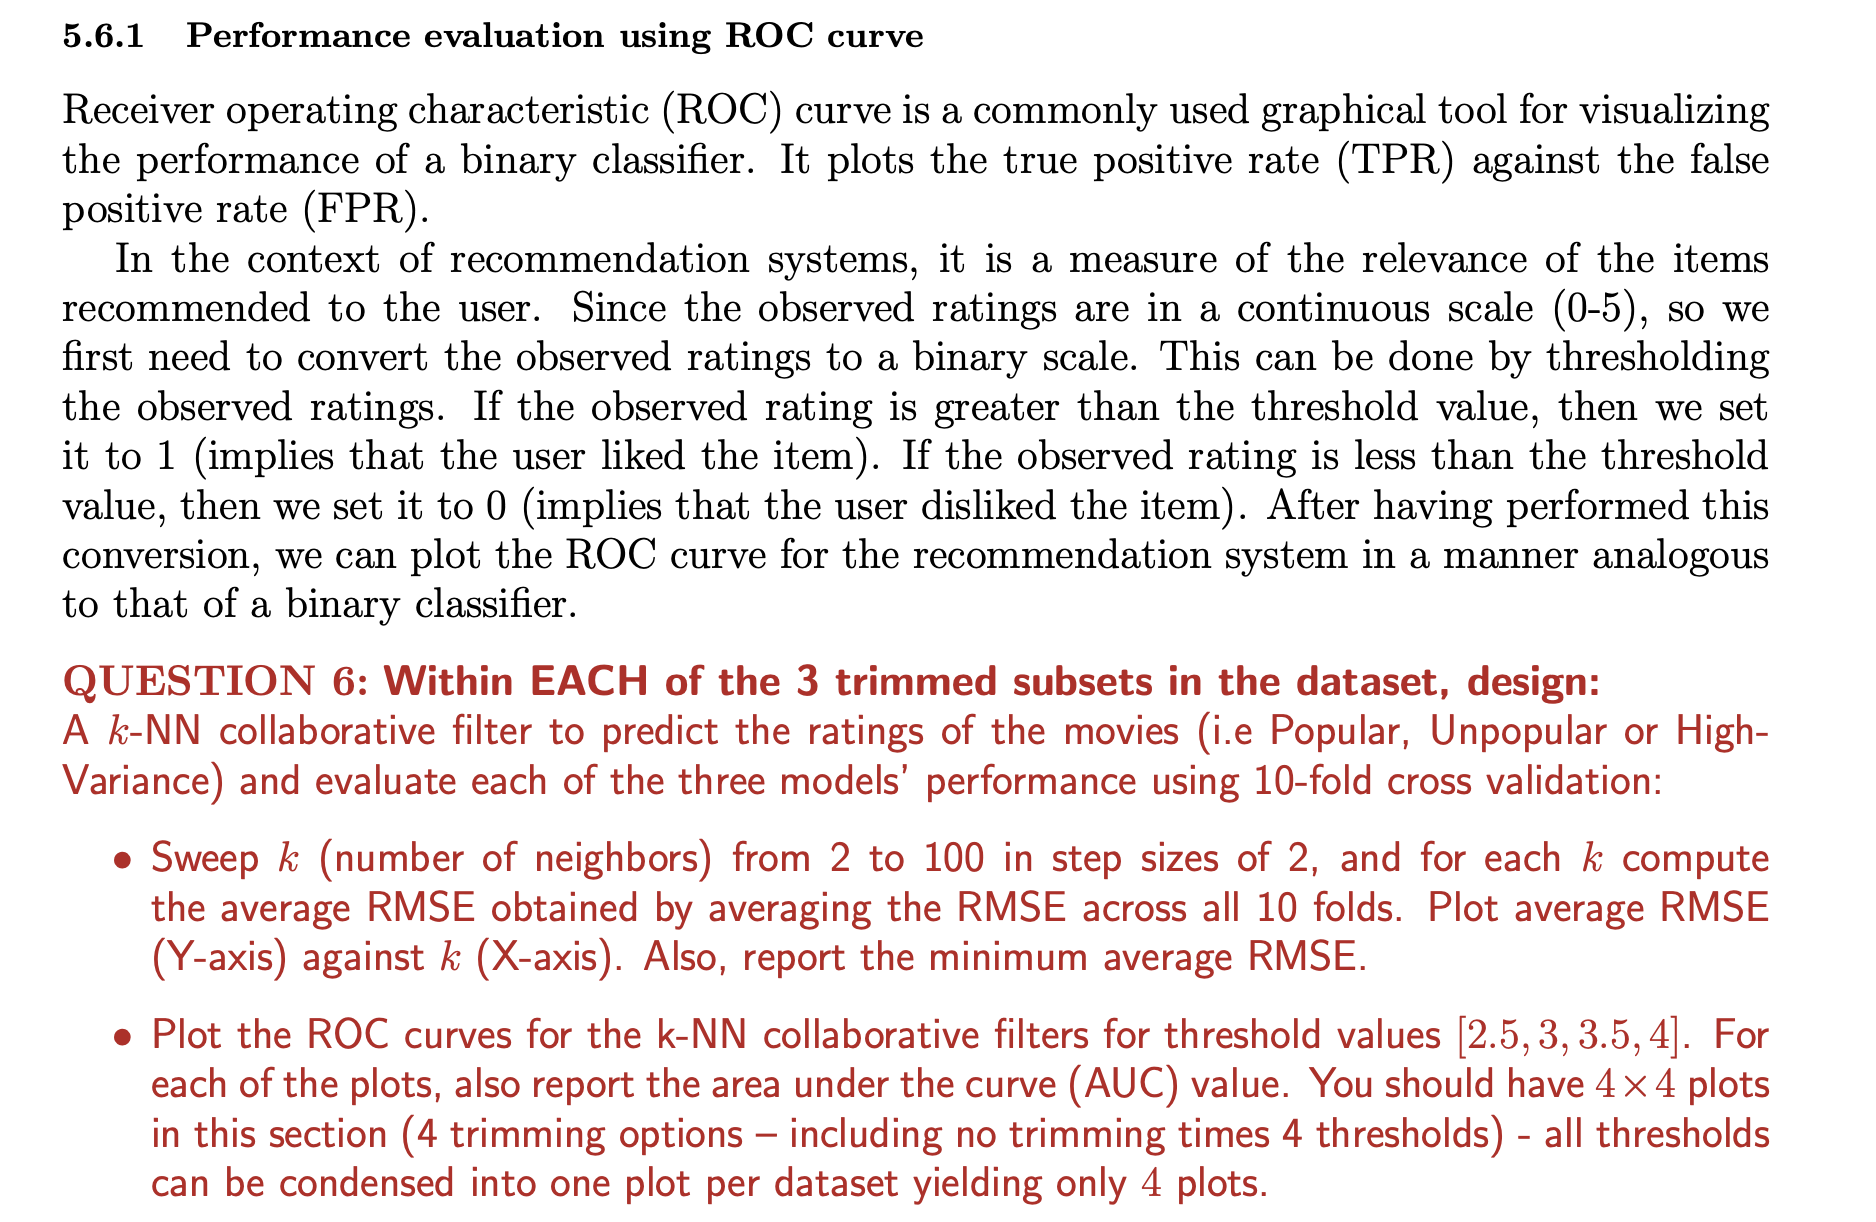

## Popular Movie Trimming

In [ ]:
from surprise.model_selection import KFold
from surprise import accuracy

kf = KFold(n_splits=10)
RMSE_pop_trim = []


for k in range(2,102,2):
  knn = KNNWithMeans(k=k, sim_options = {'name': 'pearson'})
  temp_rmse = []
  for trainset, testset in kf.split(data):
    knn.fit(trainset)
    testset = popular_movie_trimming(testset, ratings)
    predictions = knn.test(testset)
    temp_rmse.append(accuracy.rmse(predictions, verbose=True))
  RMSE_pop_trim.append(np.mean(temp_rmse))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0068
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0188
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0066
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0234


KeyboardInterrupt: ignored

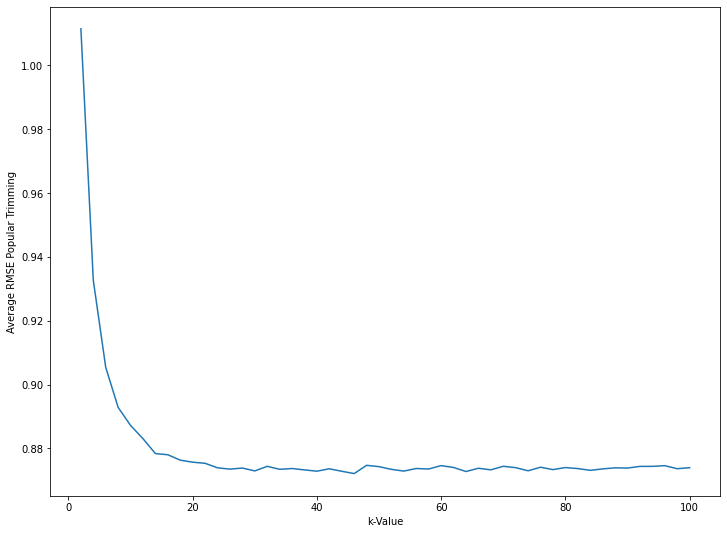

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
plt.plot(knn_k_vals, RMSE_pop_trim)
ax.set_xlabel('k-Value')
ax.set_ylabel('Average RMSE Popular Trimming')
ax.set_title('')
plt.show()

In [ ]:
print('Minimum Avg. RMSE Value: ', np.min(RMSE_pop_trim))

Minimum Avg. RMSE Value:  0.8721374810273952


Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


<Figure size 432x288 with 0 Axes>

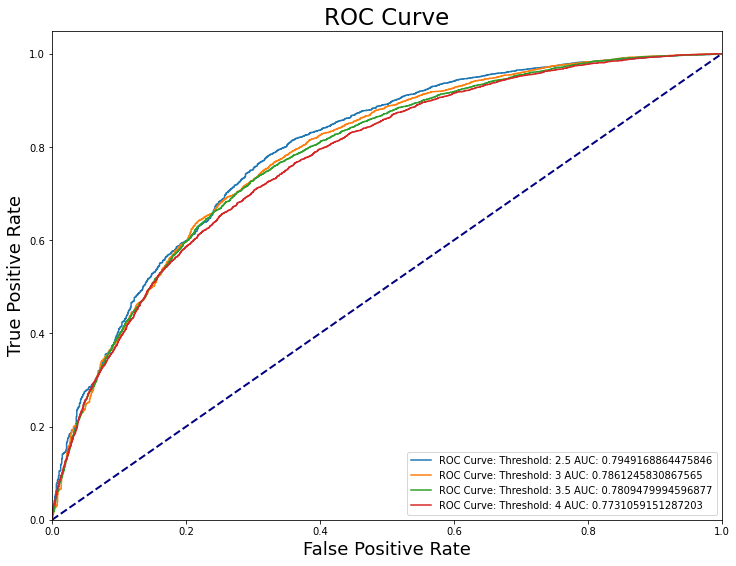

In [ ]:
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ratings_thresholds = [2.5,3,3.5,4]

fprs = []
tprs = []
AUCs = []

for threshold in ratings_thresholds:
    knn = KNNWithMeans(k=22, sim_options={'name': 'pearson'})
    trainset, testset = train_test_split(data, test_size=0.1)
    knn.fit(trainset)
    testset = popular_movie_trimming(testset, ratings)
    pred = knn.test(testset)
    
    real_y = []
    est_y = []
    for i in range(len(pred)):
        est_y.append(pred[i].est)
        if testset[i][2] >= threshold:
            real_y.append(1.0)
        else:
            real_y.append(0.0)
            
    fpr, tpr, thresholds = roc_curve(real_y, est_y)
    AUC = roc_auc_score(real_y, est_y)
    fprs.append(fpr)
    tprs.append(tpr)
    AUCs.append(AUC)

plt.gcf().clear()
plt.figure(figsize=(12,9))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve', fontsize=23)
for i in range(len(fprs)):
    plt.plot(fprs[i],tprs[i], label = 'ROC Curve: Threshold: {rt} AUC: {auc}'.format(rt=ratings_thresholds[i], auc=AUCs[i]) )
plt.legend(loc="lower right")
plt.show()

## Unpopular Movie Trimming

In [ ]:
from surprise.model_selection import KFold
from surprise import accuracy

kf = KFold(n_splits=10)
RMSE_unpop_trim = []


for k in range(2,102,2):
  knn = KNNWithMeans(k=k, sim_options = {'name': 'pearson'})
  temp_rmse = []
  for trainset, testset in kf.split(data):
    knn.fit(trainset)
    testset = unpopular_movie_trimming(testset, ratings)
    predictions = knn.test(testset)
    temp_rmse.append(accuracy.rmse(predictions, verbose=True))
  RMSE_unpop_trim.append(np.mean(temp_rmse))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0908
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1402
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0871
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1733
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1124
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1397
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1033
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0810
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1030
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0922
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1245
Computing 

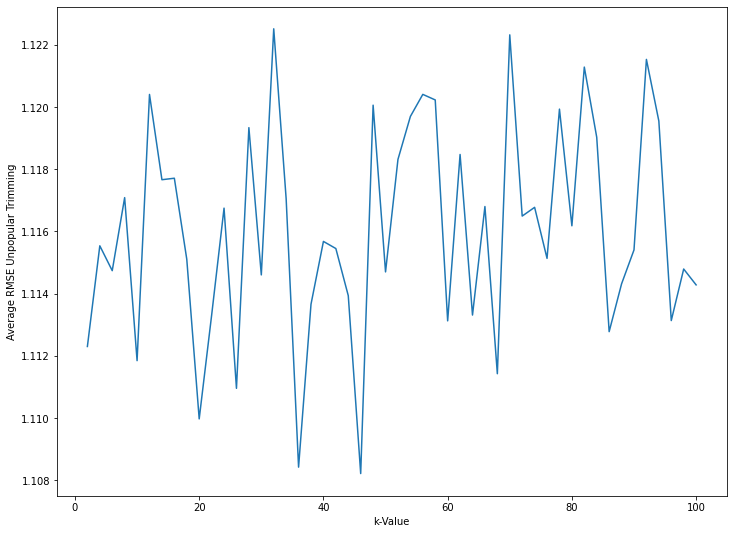

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
plt.plot(knn_k_vals, RMSE_unpop_trim)
ax.set_xlabel('k-Value')
ax.set_ylabel('Average RMSE Unpopular Trimming')
ax.set_title('')
plt.show()

In [ ]:
print('Minimum Avg. RMSE Value: ', np.min(RMSE_unpop_trim))

Minimum Avg. RMSE Value:  1.1082102848121091


Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


<Figure size 432x288 with 0 Axes>

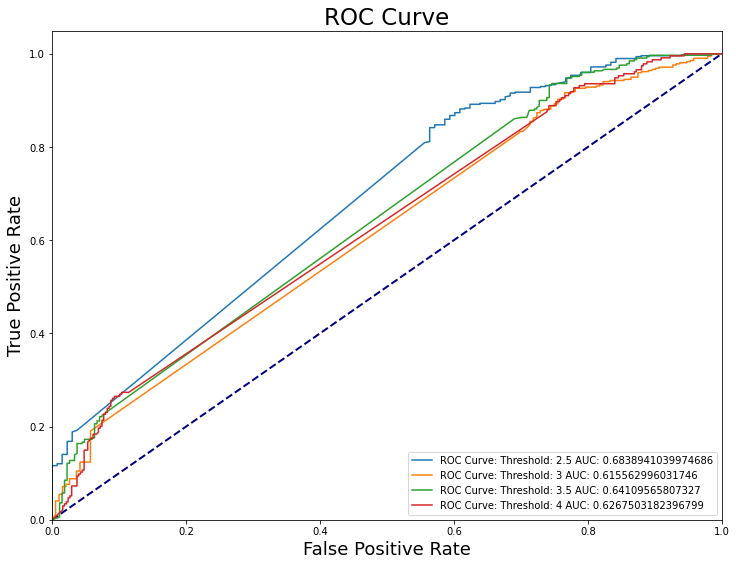

In [ ]:
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ratings_thresholds = [2.5,3,3.5,4]

fprs = []
tprs = []
AUCs = []

for threshold in ratings_thresholds:
    knn = KNNWithMeans(k=22, sim_options={'name': 'pearson'})
    trainset, testset = train_test_split(data, test_size=0.1)
    knn.fit(trainset)
    testset = unpopular_movie_trimming(testset, ratings)
    pred = knn.test(testset)
    
    real_y = []
    est_y = []
    for i in range(len(pred)):
        est_y.append(pred[i].est)
        if testset[i][2] >= threshold:
            real_y.append(1.0)
        else:
            real_y.append(0.0)
            
    fpr, tpr, thresholds = roc_curve(real_y, est_y)
    AUC = roc_auc_score(real_y, est_y)
    fprs.append(fpr)
    tprs.append(tpr)
    AUCs.append(AUC)

plt.gcf().clear()
plt.figure(figsize=(12,9))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve', fontsize=23)
for i in range(len(fprs)):
    plt.plot(fprs[i],tprs[i], label = 'ROC Curve: Threshold: {rt} AUC: {auc}'.format(rt=ratings_thresholds[i], auc=AUCs[i]) )
plt.legend(loc="lower right")
plt.show()

## High Variance Trimming

In [ ]:
from surprise.model_selection import KFold
from surprise import accuracy

kf = KFold(n_splits=10)
RMSE_highvar_trim = []


for k in range(2,102,2):
  knn = KNNWithMeans(k=k, sim_options = {'name': 'pearson'})
  temp_rmse = []
  for trainset, testset in kf.split(data):
    knn.fit(trainset)
    testset = high_variance_trimming(testset, ratings)
    predictions = knn.test(testset)
    temp_rmse.append(accuracy.rmse(predictions, verbose=True))
  RMSE_highvar_trim.append(np.mean(temp_rmse))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9698
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9675
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0118
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0322
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9962
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0032
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9923
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9789
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9688
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0270
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9365
Computing 

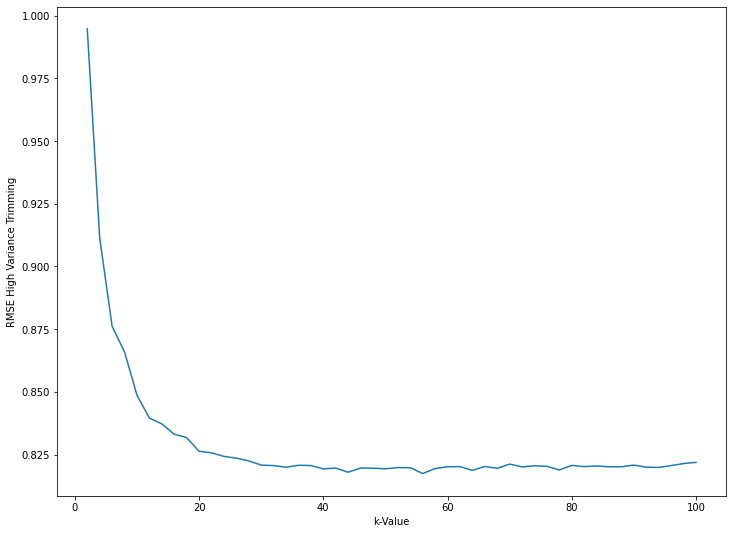

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
plt.plot(knn_k_vals, RMSE_highvar_trim)
ax.set_xlabel('k-Value')
ax.set_ylabel('RMSE High Variance Trimming')
ax.set_title('')
plt.show()

In [ ]:
print('Minimum Avg. RMSE Value: ', np.min(RMSE_highvar_trim))

Minimum Avg. RMSE Value:  0.8174102775709002


Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


<Figure size 432x288 with 0 Axes>

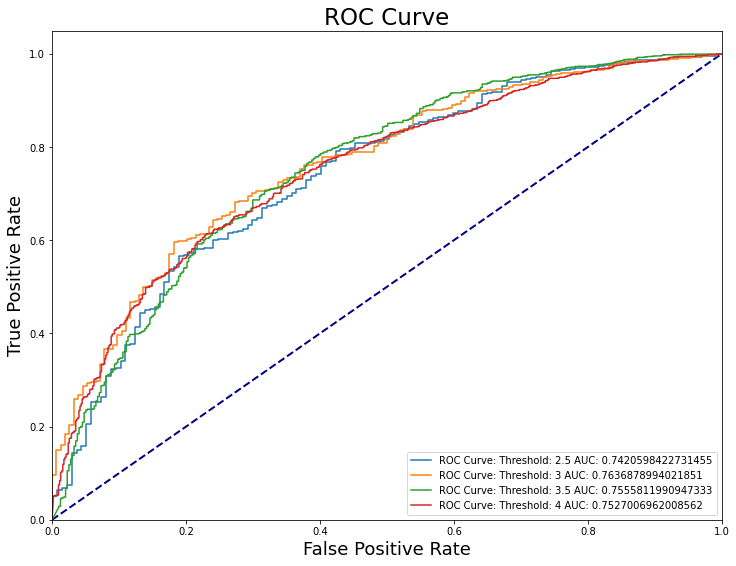

In [ ]:
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ratings_thresholds = [2.5,3,3.5,4]

fprs = []
tprs = []
AUCs = []

for threshold in ratings_thresholds:
    knn = KNNWithMeans(k=22, sim_options={'name': 'pearson'})
    trainset, testset = train_test_split(data, test_size=0.1)
    knn.fit(trainset)
    testset = high_variance_trimming(testset, ratings)
    pred = knn.test(testset)
    
    real_y = []
    est_y = []
    for i in range(len(pred)):
        est_y.append(pred[i].est)
        if testset[i][2] >= threshold:
            real_y.append(1.0)
        else:
            real_y.append(0.0)
            
    fpr, tpr, thresholds = roc_curve(real_y, est_y)
    AUC = roc_auc_score(real_y, est_y)
    fprs.append(fpr)
    tprs.append(tpr)
    AUCs.append(AUC)

plt.gcf().clear()
plt.figure(figsize=(12,9))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve', fontsize=23)
for i in range(len(fprs)):
    plt.plot(fprs[i],tprs[i], label = 'ROC Curve: Threshold: {rt} AUC: {auc}'.format(rt=ratings_thresholds[i], auc=AUCs[i]) )
plt.legend(loc="lower right")
plt.show()

## No Trimming

In [ ]:
from surprise.model_selection import KFold
from surprise import accuracy

kf = KFold(n_splits=10)
RMSE_no_trim = []


for k in range(2,102,2):
  knn = KNNWithMeans(k=k, sim_options = {'name': 'pearson'})
  temp_rmse = []
  for trainset, testset in kf.split(data):
    knn.fit(trainset)
    predictions = knn.test(testset)
    temp_rmse.append(accuracy.rmse(predictions, verbose=True))
  RMSE_no_trim.append(np.mean(temp_rmse))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0101
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0208
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0244
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0206
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0344
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0261
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0092
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0238
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0097
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0232
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9552
Computing 

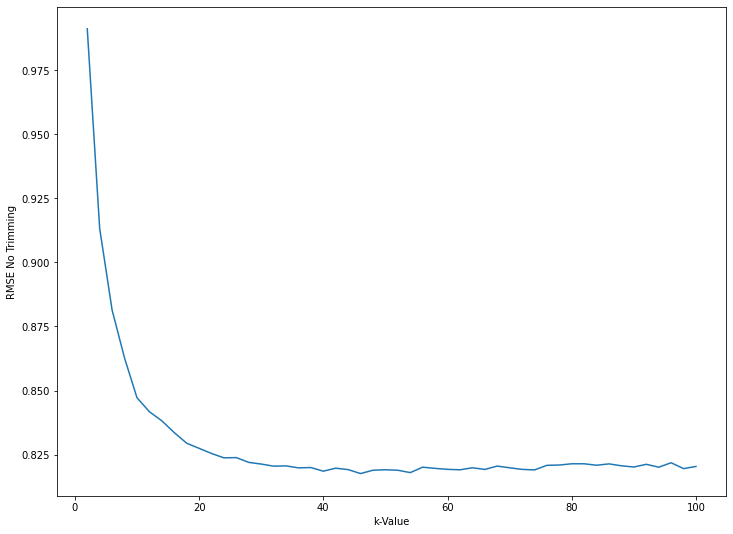

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
plt.plot(knn_k_vals, RMSE_no_trim)
ax.set_xlabel('k-Value')
ax.set_ylabel('RMSE No Trimming')
ax.set_title('')
plt.show()

In [ ]:
print('Minimum Avg. RMSE Value: ', np.min(RMSE_no_trim))

Minimum Avg. RMSE Value:  0.8889507709463145


Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


<Figure size 432x288 with 0 Axes>

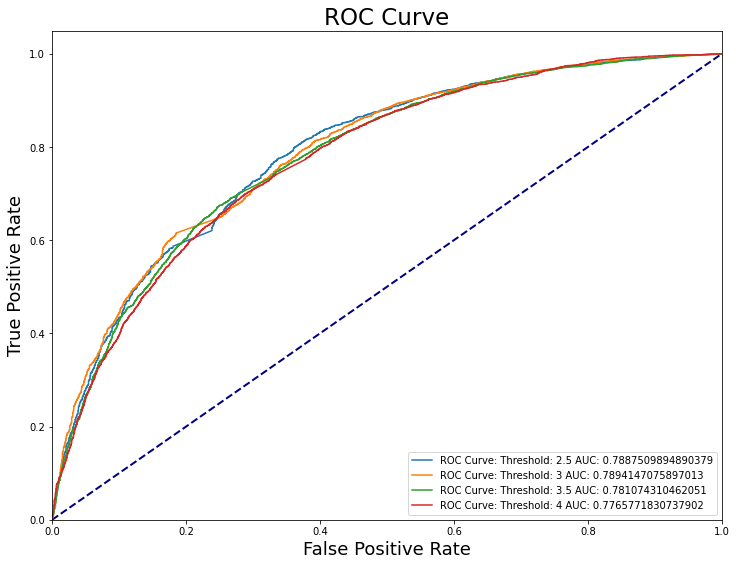

In [ ]:
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ratings_thresholds = [2.5,3,3.5,4]

fprs = []
tprs = []
AUCs = []

for threshold in ratings_thresholds:
    knn = KNNWithMeans(k=22, sim_options={'name': 'pearson'})
    trainset, testset = train_test_split(data, test_size=0.1)
    knn.fit(trainset)
    pred = knn.test(testset)
    
    real_y = []
    est_y = []
    for i in range(len(pred)):
        est_y.append(pred[i].est)
        if testset[i][2] >= threshold:
            real_y.append(1.0)
        else:
            real_y.append(0.0)
            
    fpr, tpr, thresholds = roc_curve(real_y, est_y)
    AUC = roc_auc_score(real_y, est_y)
    fprs.append(fpr)
    tprs.append(tpr)
    AUCs.append(AUC)

plt.gcf().clear()
plt.figure(figsize=(12,9))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve', fontsize=23)
for i in range(len(fprs)):
    plt.plot(fprs[i],tprs[i], label = 'ROC Curve: Threshold: {rt} AUC: {auc}'.format(rt=ratings_thresholds[i], auc=AUCs[i]) )
plt.legend(loc="lower right")
plt.show()

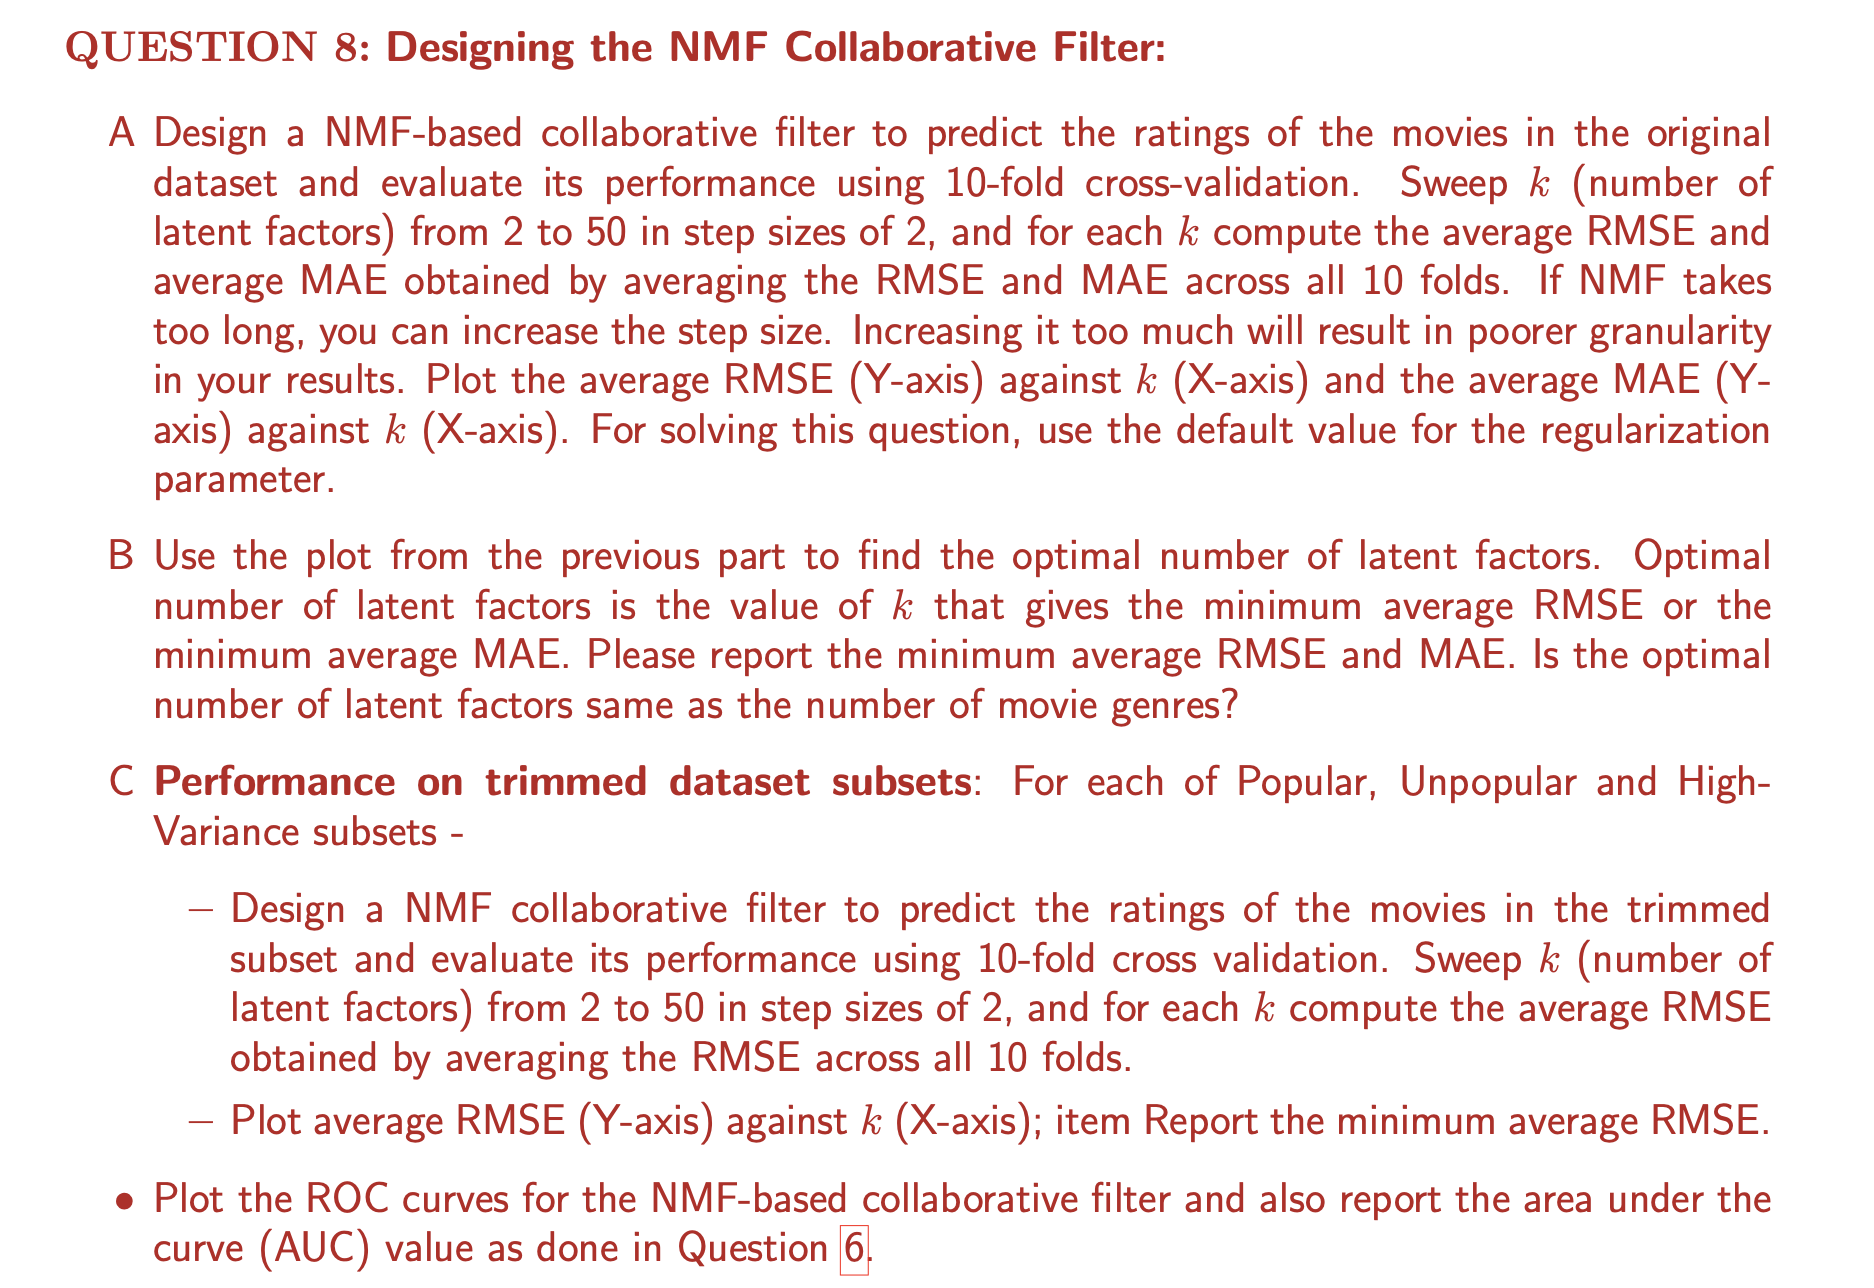

In [ ]:
from surprise.prediction_algorithms.matrix_factorization import NMF

data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)

nmf_vals = np.arange(2,52,2)
MAE_nmf, RMSE_nmf = [],[]
for k in range(2,52,2):
    nmf = NMF(n_factors=k, biased=False)
    cv = cross_validate(nmf, data, measures=['RMSE','MAE'], cv=10, verbose=False)
    RMSE_nmf.append(np.mean(cv['test_rmse']))
    MAE_nmf.append(np.mean(cv['test_mae']))

NameError: ignored

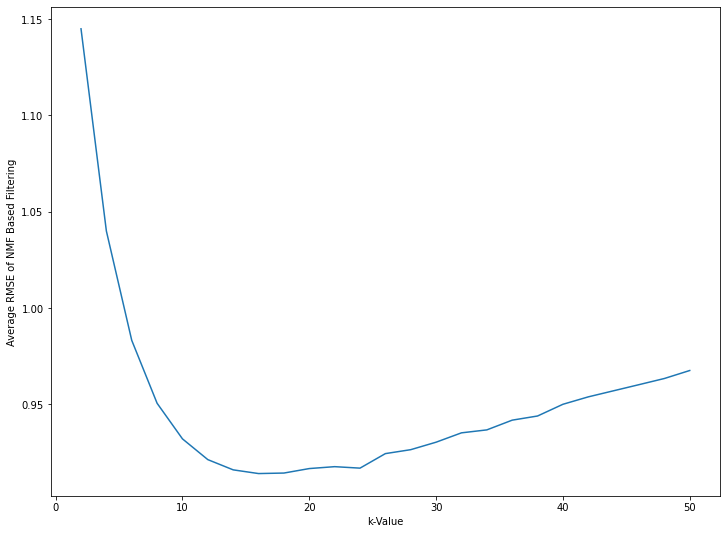

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
plt.plot(nmf_vals, RMSE_nmf)
ax.set_xlabel('k-Value')
ax.set_ylabel('Average RMSE of NMF Based Filtering')
ax.set_title('')
plt.show()

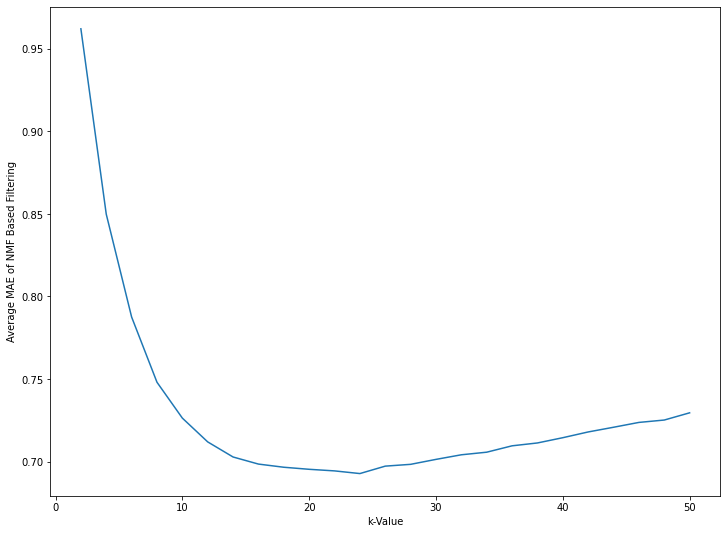

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
plt.plot(nmf_vals, MAE_nmf)
ax.set_xlabel('k-Value')
ax.set_ylabel('Average MAE of NMF Based Filtering')
ax.set_title('')
plt.show()

In [ ]:
k_rmse = np.argmin(RMSE_nmf)
k_nmf = np.argmin(MAE_nmf)
print('Optimal Latent Factors RMSE: ', k_rmse*2)
print('Optimal Latent Factors MAE: ', k_nmf*2)
print('Avg. Value RMSE: ', np.min(RMSE_nmf))
print('Avg. Value MAE: ', np.min(MAE_nmf))

Optimal Latent Factors RMSE:  14
Optimal Latent Factors MAE:  22
Avg. Value RMSE:  0.9139651022190989
Avg. Value MAE:  0.6927652749402957


In [ ]:
import re
all_genres = ''.join(df_movies.genres)
all_genres = all_genres.split("|")
all_genres = ''.join(all_genres)
all_genres = re.findall('[A-Z][^A-Z]*', all_genres)
np.unique(all_genres) 

array(['A', 'Action', 'Adventure', 'Adventure(no genres listed)',
       'Animation', 'Animation(no genres listed)', 'Children', 'Comedy',
       'Comedy(no genres listed)', 'Crime', 'Documentary',
       'Documentary(no genres listed)',
       'Documentary(no genres listed)(no genres listed)', 'Drama',
       'Drama(no genres listed)', 'Fantasy', 'Fantasy(no genres listed)',
       'Fi', 'Fi(no genres listed)', 'Film-', 'Horror',
       'Horror(no genres listed)', 'I', 'M', 'Musical', 'Mystery', 'Noir',
       'Romance', 'Romance(no genres listed)', 'Sci-', 'Thriller',
       'Thriller(no genres listed)', 'War', 'Western', 'X',
       'X(no genres listed)'], dtype='<U47')

## Popular Trimming NMF

In [ ]:
from surprise import accuracy

kf = KFold(n_splits=10)
RMSE_pop_trim_nmf = []


for k in range(2,52,2):
  nmf = NMF(n_factors=k, biased=False)
  temp_rmse = []
  for trainset, testset in kf.split(data):
    nmf.fit(trainset)
    testset = popular_movie_trimming(testset, ratings)
    predictions = knn.test(testset)
    temp_rmse.append(accuracy.rmse(predictions, verbose=True))
  RMSE_pop_trim_nmf.append(np.mean(temp_rmse))

RMSE: 0.6573


KeyboardInterrupt: ignored

In [ ]:
print('Minimum Avg RMSE Value: ', np.min(RMSE_pop_trim_nmf))

Minimum Avg RMSE Value:  0.5377907904097727


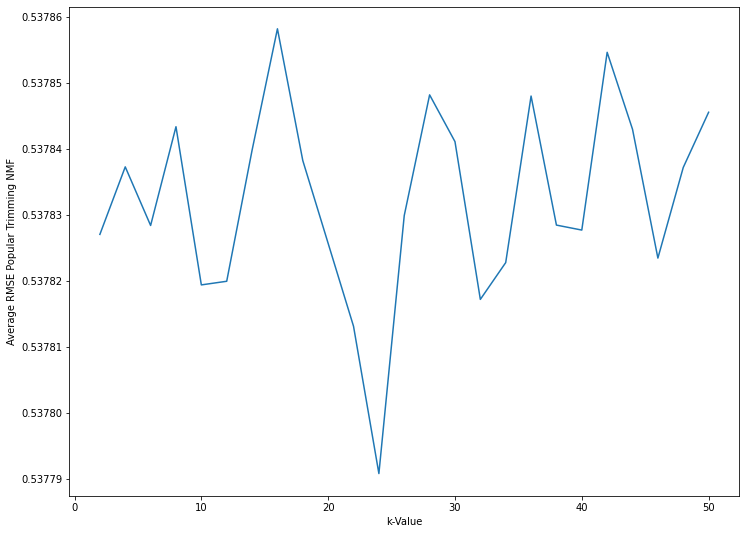

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
plt.plot(nmf_vals, RMSE_pop_trim_nmf)
ax.set_xlabel('k-Value')
ax.set_ylabel('Average RMSE Popular Trimming NMF')
ax.set_title('')
plt.show()

<Figure size 432x288 with 0 Axes>

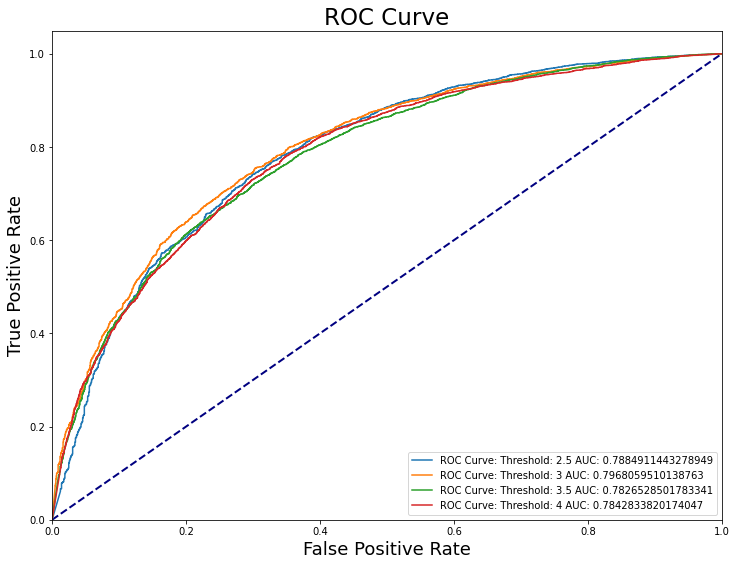

In [ ]:
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ratings_thresholds = [2.5,3,3.5,4]

fprs = []
tprs = []
AUCs = []

for threshold in ratings_thresholds:
    nmf = NMF(n_factors=k, biased=False)
    trainset, testset = train_test_split(data, test_size=0.1)
    nmf.fit(trainset)
    testset = popular_movie_trimming(testset, ratings)
    pred = nmf.test(testset)
    
    real_y = []
    est_y = []
    for i in range(len(pred)):
        est_y.append(pred[i].est)
        if testset[i][2] >= threshold:
            real_y.append(1.0)
        else:
            real_y.append(0.0)
            
    fpr, tpr, thresholds = roc_curve(real_y, est_y)
    AUC = roc_auc_score(real_y, est_y)
    fprs.append(fpr)
    tprs.append(tpr)
    AUCs.append(AUC)

plt.gcf().clear()
plt.figure(figsize=(12,9))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve', fontsize=23)
for i in range(len(fprs)):
    plt.plot(fprs[i],tprs[i], label = 'ROC Curve: Threshold: {rt} AUC: {auc}'.format(rt=ratings_thresholds[i], auc=AUCs[i]) )
plt.legend(loc="lower right")
plt.show()

## Unpopular Trimming NMF



In [ ]:
from surprise import accuracy

kf = KFold(n_splits=10)
RMSE_unpop_trim_nmf = []


for k in range(2,52,2):
  nmf = NMF(n_factors=k, biased=False)
  temp_rmse = []
  for trainset, testset in kf.split(data):
    nmf.fit(trainset)
    testset = unpopular_movie_trimming(testset, ratings)
    predictions = knn.test(testset)
    temp_rmse.append(accuracy.rmse(predictions, verbose=True))
  RMSE_unpop_trim_nmf.append(np.mean(temp_rmse))

RMSE: 0.4005
RMSE: 0.3724
RMSE: 0.4146
RMSE: 0.3658
RMSE: 0.4018
RMSE: 0.4281
RMSE: 0.3577
RMSE: 0.3665
RMSE: 0.4122
RMSE: 0.4046
RMSE: 0.3249
RMSE: 0.4156
RMSE: 0.4200
RMSE: 0.3822
RMSE: 0.3390
RMSE: 0.3681
RMSE: 0.4318
RMSE: 0.4585
RMSE: 0.3753
RMSE: 0.3886
RMSE: 0.3998
RMSE: 0.3448
RMSE: 0.3461
RMSE: 0.4440
RMSE: 0.3506
RMSE: 0.4848
RMSE: 0.4360
RMSE: 0.3779
RMSE: 0.4000
RMSE: 0.3017
RMSE: 0.3609
RMSE: 0.3982
RMSE: 0.4539
RMSE: 0.3466
RMSE: 0.3991
RMSE: 0.3990
RMSE: 0.3603
RMSE: 0.4021
RMSE: 0.3373
RMSE: 0.4506
RMSE: 0.3840
RMSE: 0.4038
RMSE: 0.3535
RMSE: 0.4411
RMSE: 0.3952
RMSE: 0.3517
RMSE: 0.4214
RMSE: 0.3138
RMSE: 0.4725
RMSE: 0.3651
RMSE: 0.4189
RMSE: 0.3877
RMSE: 0.3553
RMSE: 0.3652
RMSE: 0.4697
RMSE: 0.4261
RMSE: 0.3636
RMSE: 0.3154
RMSE: 0.3838
RMSE: 0.4202
RMSE: 0.4335
RMSE: 0.3626
RMSE: 0.4184
RMSE: 0.4215
RMSE: 0.3815
RMSE: 0.2991
RMSE: 0.4160
RMSE: 0.4022
RMSE: 0.4122
RMSE: 0.3642
RMSE: 0.3702
RMSE: 0.3607
RMSE: 0.4151
RMSE: 0.3353
RMSE: 0.4070
RMSE: 0.3475
RMSE: 0.3941

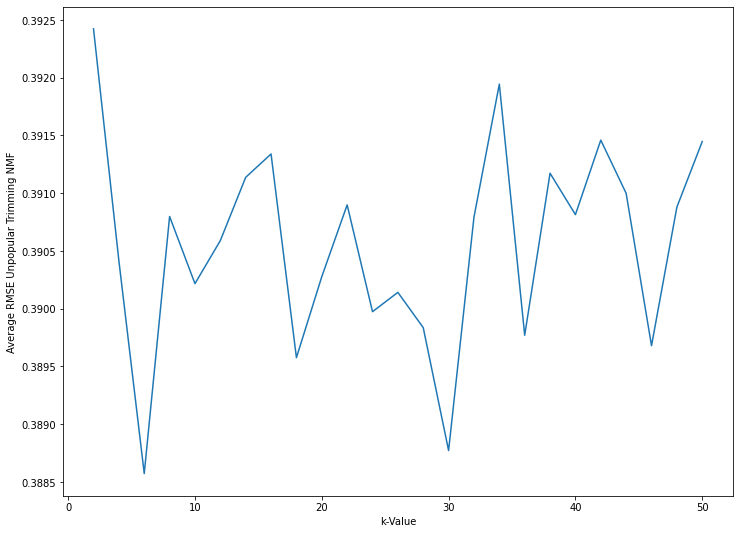

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
plt.plot(nmf_vals, RMSE_unpop_trim_nmf)
ax.set_xlabel('k-Value')
ax.set_ylabel('Average RMSE Unpopular Trimming NMF')
ax.set_title('')
plt.show()

In [ ]:
print('Minimum Avg RMSE Value: ', np.min(RMSE_unpop_trim_nmf))

Minimum Avg RMSE Value:  0.388572393683762


<Figure size 432x288 with 0 Axes>

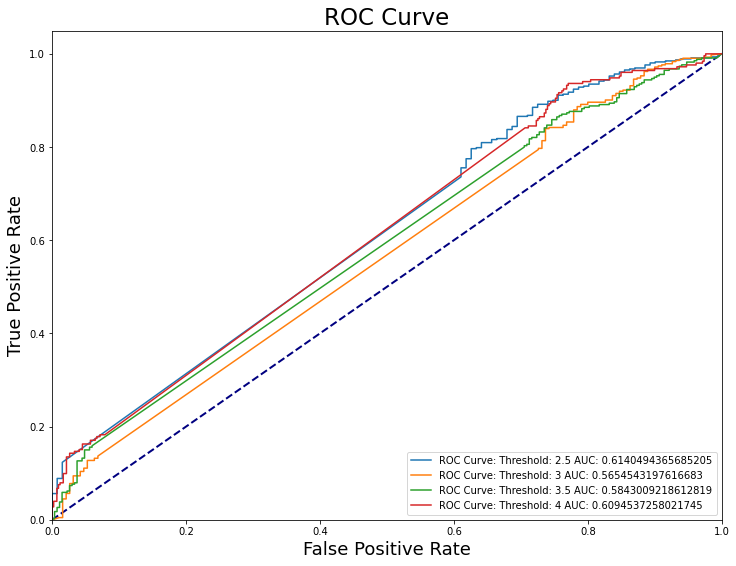

In [ ]:
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ratings_thresholds = [2.5,3,3.5,4]

fprs = []
tprs = []
AUCs = []

for threshold in ratings_thresholds:
    nmf = NMF(n_factors=k, biased=False)
    trainset, testset = train_test_split(data, test_size=0.1)
    nmf.fit(trainset)
    testset = unpopular_movie_trimming(testset, ratings)
    pred = nmf.test(testset)
    
    real_y = []
    est_y = []
    for i in range(len(pred)):
        est_y.append(pred[i].est)
        if testset[i][2] >= threshold:
            real_y.append(1.0)
        else:
            real_y.append(0.0)
            
    fpr, tpr, thresholds = roc_curve(real_y, est_y)
    AUC = roc_auc_score(real_y, est_y)
    fprs.append(fpr)
    tprs.append(tpr)
    AUCs.append(AUC)

plt.gcf().clear()
plt.figure(figsize=(12,9))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve', fontsize=23)
for i in range(len(fprs)):
    plt.plot(fprs[i],tprs[i], label = 'ROC Curve: Threshold: {rt} AUC: {auc}'.format(rt=ratings_thresholds[i], auc=AUCs[i]) )
plt.legend(loc="lower right")
plt.show()

## High Variance Trimming NMF



In [ ]:
from surprise import accuracy

kf = KFold(n_splits=10)
RMSE_highvar_trim_nmf = []


for k in range(2,52,2):
  nmf = NMF(n_factors=k, biased=False)
  temp_rmse = []
  for trainset, testset in kf.split(data):
    nmf.fit(trainset)
    testset = high_variance_trimming(testset, ratings)
    predictions = knn.test(testset)
    temp_rmse.append(accuracy.rmse(predictions, verbose=True))
  RMSE_highvar_trim_nmf.append(np.mean(temp_rmse))

RMSE: 0.5531
RMSE: 0.5519
RMSE: 0.5107
RMSE: 0.5676
RMSE: 0.5333
RMSE: 0.5411
RMSE: 0.5417
RMSE: 0.5563
RMSE: 0.5275
RMSE: 0.5344
RMSE: 0.5110
RMSE: 0.5170
RMSE: 0.5485
RMSE: 0.5410
RMSE: 0.5536
RMSE: 0.5259
RMSE: 0.5432
RMSE: 0.5797
RMSE: 0.5584
RMSE: 0.5396
RMSE: 0.5548
RMSE: 0.5299
RMSE: 0.5325
RMSE: 0.5751
RMSE: 0.5209
RMSE: 0.5362
RMSE: 0.5227
RMSE: 0.5313
RMSE: 0.5518
RMSE: 0.5602
RMSE: 0.5314
RMSE: 0.5468
RMSE: 0.5343
RMSE: 0.5415
RMSE: 0.5519
RMSE: 0.5347
RMSE: 0.5433
RMSE: 0.5414
RMSE: 0.5421
RMSE: 0.5522
RMSE: 0.5598
RMSE: 0.5421
RMSE: 0.5428
RMSE: 0.5305
RMSE: 0.5248
RMSE: 0.5442
RMSE: 0.5444
RMSE: 0.5576
RMSE: 0.5276
RMSE: 0.5450
RMSE: 0.5510
RMSE: 0.5405
RMSE: 0.5540
RMSE: 0.5488
RMSE: 0.5231
RMSE: 0.5534
RMSE: 0.5267
RMSE: 0.5553
RMSE: 0.5354
RMSE: 0.5303
RMSE: 0.5355
RMSE: 0.5441
RMSE: 0.5565
RMSE: 0.5364
RMSE: 0.5440
RMSE: 0.5566
RMSE: 0.5345
RMSE: 0.5520
RMSE: 0.5386
RMSE: 0.5223
RMSE: 0.5193
RMSE: 0.5525
RMSE: 0.5347
RMSE: 0.5469
RMSE: 0.5690
RMSE: 0.5561
RMSE: 0.5397

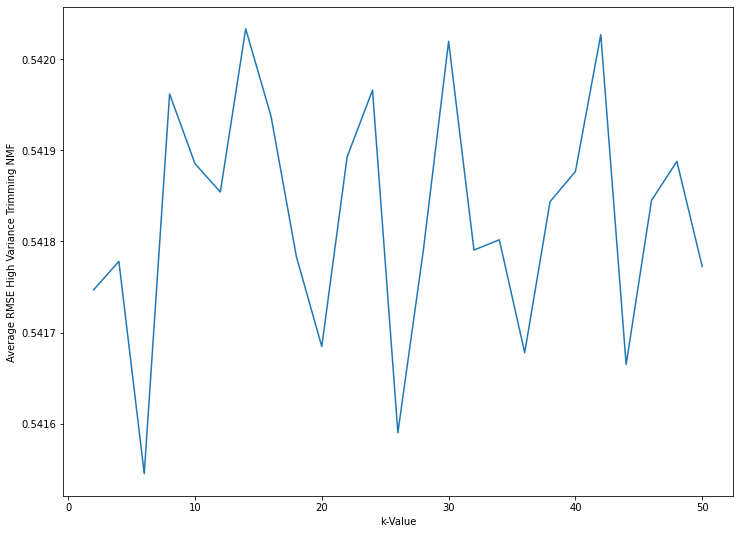

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
plt.plot(nmf_vals, RMSE_highvar_trim_nmf)
ax.set_xlabel('k-Value')
ax.set_ylabel('Average RMSE High Variance Trimming NMF')
ax.set_title('')
plt.show()

In [ ]:
print('Minimum Avg RMSE Value: ', np.min(RMSE_highvar_trim_nmf))

Minimum Avg RMSE Value:  0.5415453163618383


<Figure size 432x288 with 0 Axes>

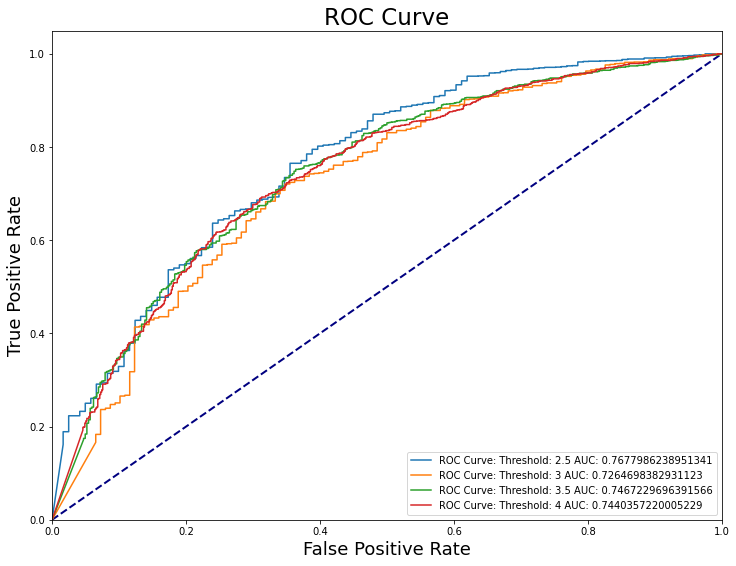

In [ ]:
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ratings_thresholds = [2.5,3,3.5,4]

fprs = []
tprs = []
AUCs = []

for threshold in ratings_thresholds:
    nmf = NMF(n_factors=k, biased=False)
    trainset, testset = train_test_split(data, test_size=0.1)
    nmf.fit(trainset)
    testset = high_variance_trimming(testset, ratings)
    pred = nmf.test(testset)
    
    real_y = []
    est_y = []
    for i in range(len(pred)):
        est_y.append(pred[i].est)
        if testset[i][2] >= threshold:
            real_y.append(1.0)
        else:
            real_y.append(0.0)
            
    fpr, tpr, thresholds = roc_curve(real_y, est_y)
    AUC = roc_auc_score(real_y, est_y)
    fprs.append(fpr)
    tprs.append(tpr)
    AUCs.append(AUC)

plt.gcf().clear()
plt.figure(figsize=(12,9))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve', fontsize=23)
for i in range(len(fprs)):
    plt.plot(fprs[i],tprs[i], label = 'ROC Curve: Threshold: {rt} AUC: {auc}'.format(rt=ratings_thresholds[i], auc=AUCs[i]) )
plt.legend(loc="lower right")
plt.show()

## No Trimming NMF

In [ ]:
from surprise import accuracy

kf = KFold(n_splits=10)
RMSE_nmf = []


for k in range(2,52,2):
  nmf = NMF(n_factors=k, biased=False)
  temp_rmse = []
  for trainset, testset in kf.split(data):
    nmf.fit(trainset)
    predictions = knn.test(testset)
    temp_rmse.append(accuracy.rmse(predictions, verbose=True))
  RMSE_nmf.append(np.mean(temp_rmse))

RMSE: 0.6463
RMSE: 0.6438
RMSE: 0.6569
RMSE: 0.6404
RMSE: 0.6434
RMSE: 0.6429
RMSE: 0.6589
RMSE: 0.6492
RMSE: 0.6464
RMSE: 0.6484
RMSE: 0.6493
RMSE: 0.6510
RMSE: 0.6478
RMSE: 0.6505
RMSE: 0.6482
RMSE: 0.6407
RMSE: 0.6412
RMSE: 0.6569
RMSE: 0.6412
RMSE: 0.6500
RMSE: 0.6487
RMSE: 0.6368
RMSE: 0.6497
RMSE: 0.6499
RMSE: 0.6565
RMSE: 0.6444
RMSE: 0.6508
RMSE: 0.6456
RMSE: 0.6504
RMSE: 0.6439
RMSE: 0.6469
RMSE: 0.6506
RMSE: 0.6461
RMSE: 0.6551
RMSE: 0.6401
RMSE: 0.6332
RMSE: 0.6654
RMSE: 0.6447
RMSE: 0.6475
RMSE: 0.6468
RMSE: 0.6390
RMSE: 0.6518
RMSE: 0.6428
RMSE: 0.6474
RMSE: 0.6501
RMSE: 0.6463
RMSE: 0.6488
RMSE: 0.6508
RMSE: 0.6517
RMSE: 0.6481
RMSE: 0.6436
RMSE: 0.6509
RMSE: 0.6408
RMSE: 0.6324
RMSE: 0.6654
RMSE: 0.6445
RMSE: 0.6507
RMSE: 0.6441
RMSE: 0.6551
RMSE: 0.6489
RMSE: 0.6459
RMSE: 0.6591
RMSE: 0.6478
RMSE: 0.6466
RMSE: 0.6503
RMSE: 0.6406
RMSE: 0.6475
RMSE: 0.6533
RMSE: 0.6517
RMSE: 0.6337
RMSE: 0.6540
RMSE: 0.6499
RMSE: 0.6427
RMSE: 0.6561
RMSE: 0.6449
RMSE: 0.6427
RMSE: 0.6515

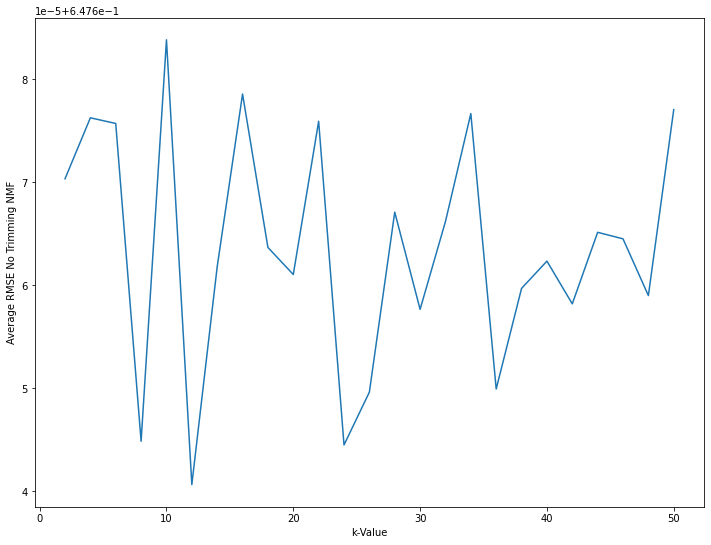

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
nmf_vals = np.arange(2,52,2)
plt.plot(nmf_vals, RMSE_nmf)
ax.set_xlabel('k-Value')
ax.set_ylabel('Average RMSE No Trimming NMF')
ax.set_title('')
plt.show()

In [ ]:
print('Minimum Avg RMSE Value: ', np.min(RMSE_nmf))

Minimum Avg RMSE Value:  0.6476406433502836


<Figure size 432x288 with 0 Axes>

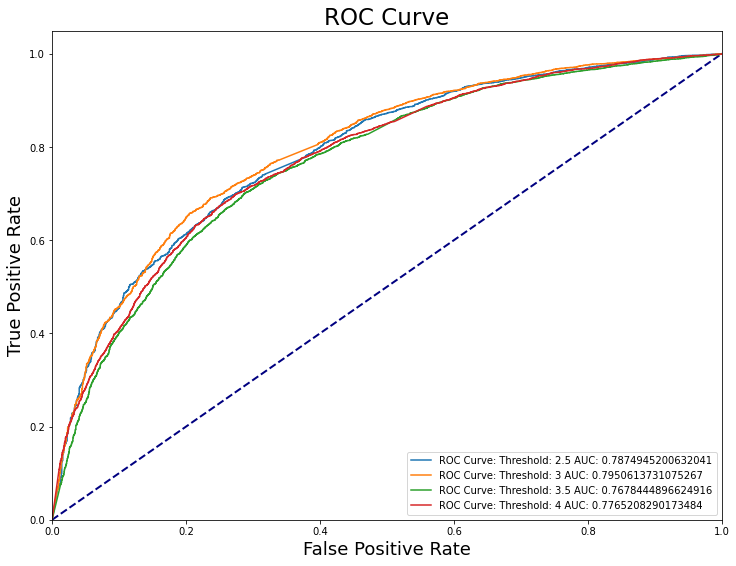

In [ ]:
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ratings_thresholds = [2.5,3,3.5,4]

fprs = []
tprs = []
AUCs = []

for threshold in ratings_thresholds:
    nmf = NMF(n_factors=k, biased=False)
    trainset, testset = train_test_split(data, test_size=0.1)
    nmf.fit(trainset)
    pred = nmf.test(testset)
    
    real_y = []
    est_y = []
    for i in range(len(pred)):
        est_y.append(pred[i].est)
        if testset[i][2] >= threshold:
            real_y.append(1.0)
        else:
            real_y.append(0.0)
            
    fpr, tpr, thresholds = roc_curve(real_y, est_y)
    AUC = roc_auc_score(real_y, est_y)
    fprs.append(fpr)
    tprs.append(tpr)
    AUCs.append(AUC)

plt.gcf().clear()
plt.figure(figsize=(12,9))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve', fontsize=23)
for i in range(len(fprs)):
    plt.plot(fprs[i],tprs[i], label = 'ROC Curve: Threshold: {rt} AUC: {auc}'.format(rt=ratings_thresholds[i], auc=AUCs[i]) )
plt.legend(loc="lower right")
plt.show()

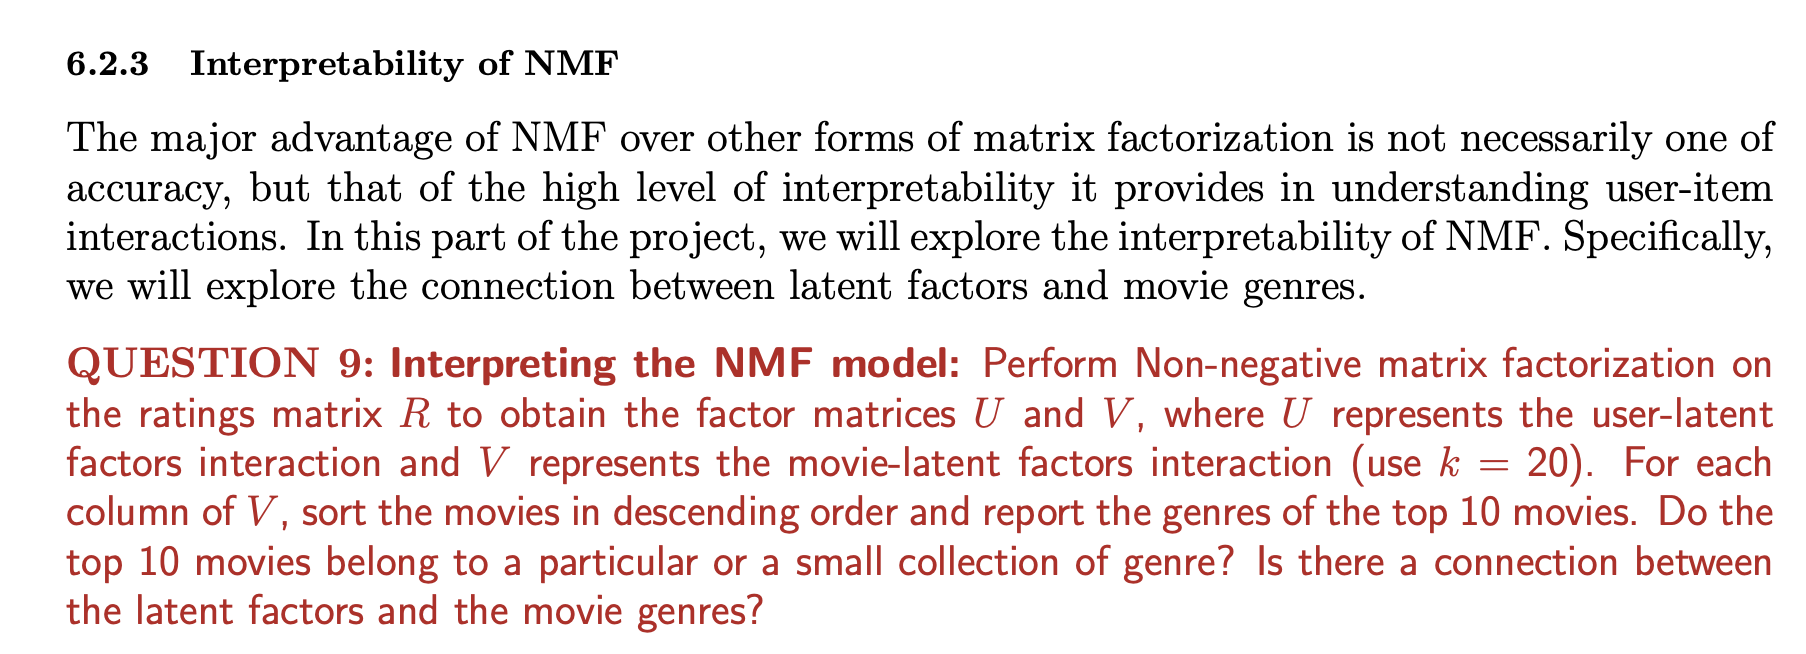

In [ ]:
from surprise.model_selection import train_test_split

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(.5, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=.1)
nmf = NMF(n_factors=20,verbose=False)
nmf.fit(trainset).test(testset)
V = nmf.qi
k = [0,5,10,15,16,17,18,19]
df = pd.read_csv('Synthetic_Movie_Lens/movies.csv',names=['movieid','title','genres'],header=0)
for i in k:
    print(i)
    mov = V[:,i]
    mov1 = [(n,j) for n,j in enumerate(mov)]
    mov1.sort(key = lambda x:x[1], reverse=True)
    for a in mov1[:10]:
        print(df['genres'][a[0]])

0
Comedy|Western
Drama
Comedy
Drama
Action|Adventure|Sci-Fi
Drama
Action|War
Drama
Horror|Thriller
Drama|Sci-Fi
5
Drama|Mystery
Drama|Romance
Thriller
Drama|Romance
Action|Comedy|Romance
Drama
Comedy
Adventure|Children|Comedy|Fantasy
Action|Adventure|Drama
Action|Fantasy|Horror|Romance
10
Action|Adventure|Drama|Fantasy|Thriller
Comedy|Drama
Drama|Thriller
Action|Sci-Fi|Thriller
Comedy|Drama|Romance
Action
Drama|Fantasy|Mystery|Romance
Drama
Animation|Children|Comedy
Drama|Horror|Mystery|Romance|Thriller
15
Action|Crime
Drama|Film-Noir|Thriller
Comedy
Action|Adventure|Sci-Fi
Animation|Comedy
Action|Adventure|Comedy|Sci-Fi
Comedy|Fantasy|Mystery
Drama
Animation|Children|Musical
Crime|Drama|Thriller
16
Drama
Comedy|Drama
Drama
Comedy|Documentary|Romance
Drama|Fantasy|Thriller
Adventure|Children|Romance
Adventure|Animation|Children|Comedy|IMAX
Action|Drama
Animation
Adventure|Animation|Children|Comedy|Fantasy
17
Comedy|Drama
Adventure|Comedy|Fantasy|Horror
Drama|Film-Noir|Thriller
Comedy|C

In [ ]:
from surprise import Reader
from surprise import Dataset
from surprise.prediction_algorithms import NMF

import csv

counter = 1

df_movies.reset_index()
genres = {row[0]: row[1][2] for row in df_movies.T.iteritems()}

reader = Reader(sep=',', rating_scale=(0.0, 5.0), skip_lines=1)
allMovies = Dataset.load_from_file('Synthetic_Movie_Lens/ratings.csv', reader=reader)

nmf = NMF(n_factors=20)
train_all_movies = allMovies.build_full_trainset()

nmf.fit(train_all_movies)

V = nmf.qi
for c in range(20):
    print("Top 10 Values in Column")
    sort_indices = np.argsort(-1*V[:,c])[0:10]
    print(V[sort_indices[0:10],c])
    print("Genres of Corresponding Movies:")
    for i in sort_indices:
        print(genres[int(train_all_movies.to_raw_iid(i))])

    print("")

Top 10 Values in Column
[1.40805181 1.35904474 1.31192772 1.26484085 1.25732813 1.24203812
 1.22875198 1.22466481 1.21135131 1.21096301]
Genres of Corresponding Movies:
Comedy|Drama|Romance
Adventure|Children
Comedy|Crime|Drama
Adventure|Animation|Children|Fantasy|Musical
Comedy|Drama
Drama|Fantasy|Horror|Thriller
Drama
Action|Adventure
Action|Drama|Sci-Fi
Adventure|Drama|Sci-Fi

Top 10 Values in Column
[1.37243456 1.33098581 1.30139707 1.2797743  1.26519938 1.26327719
 1.26040975 1.24786804 1.2464654  1.23473253]
Genres of Corresponding Movies:
Comedy|Drama|Romance|Thriller
Action|Sci-Fi|Thriller
Children
Drama|Romance
Drama
Drama|Musical
Adventure|Drama
Adventure|Animation|Children|Fantasy|Musical
Thriller
Comedy|Romance

Top 10 Values in Column
[1.63700705 1.53628302 1.4831309  1.41736562 1.39937324 1.36314187
 1.32671672 1.30987607 1.29833328 1.29044518]
Genres of Corresponding Movies:
Action|Drama|Sci-Fi
Comedy
Action|Crime|Drama|War
Comedy|Drama
Adventure|Children|Romance
Childre

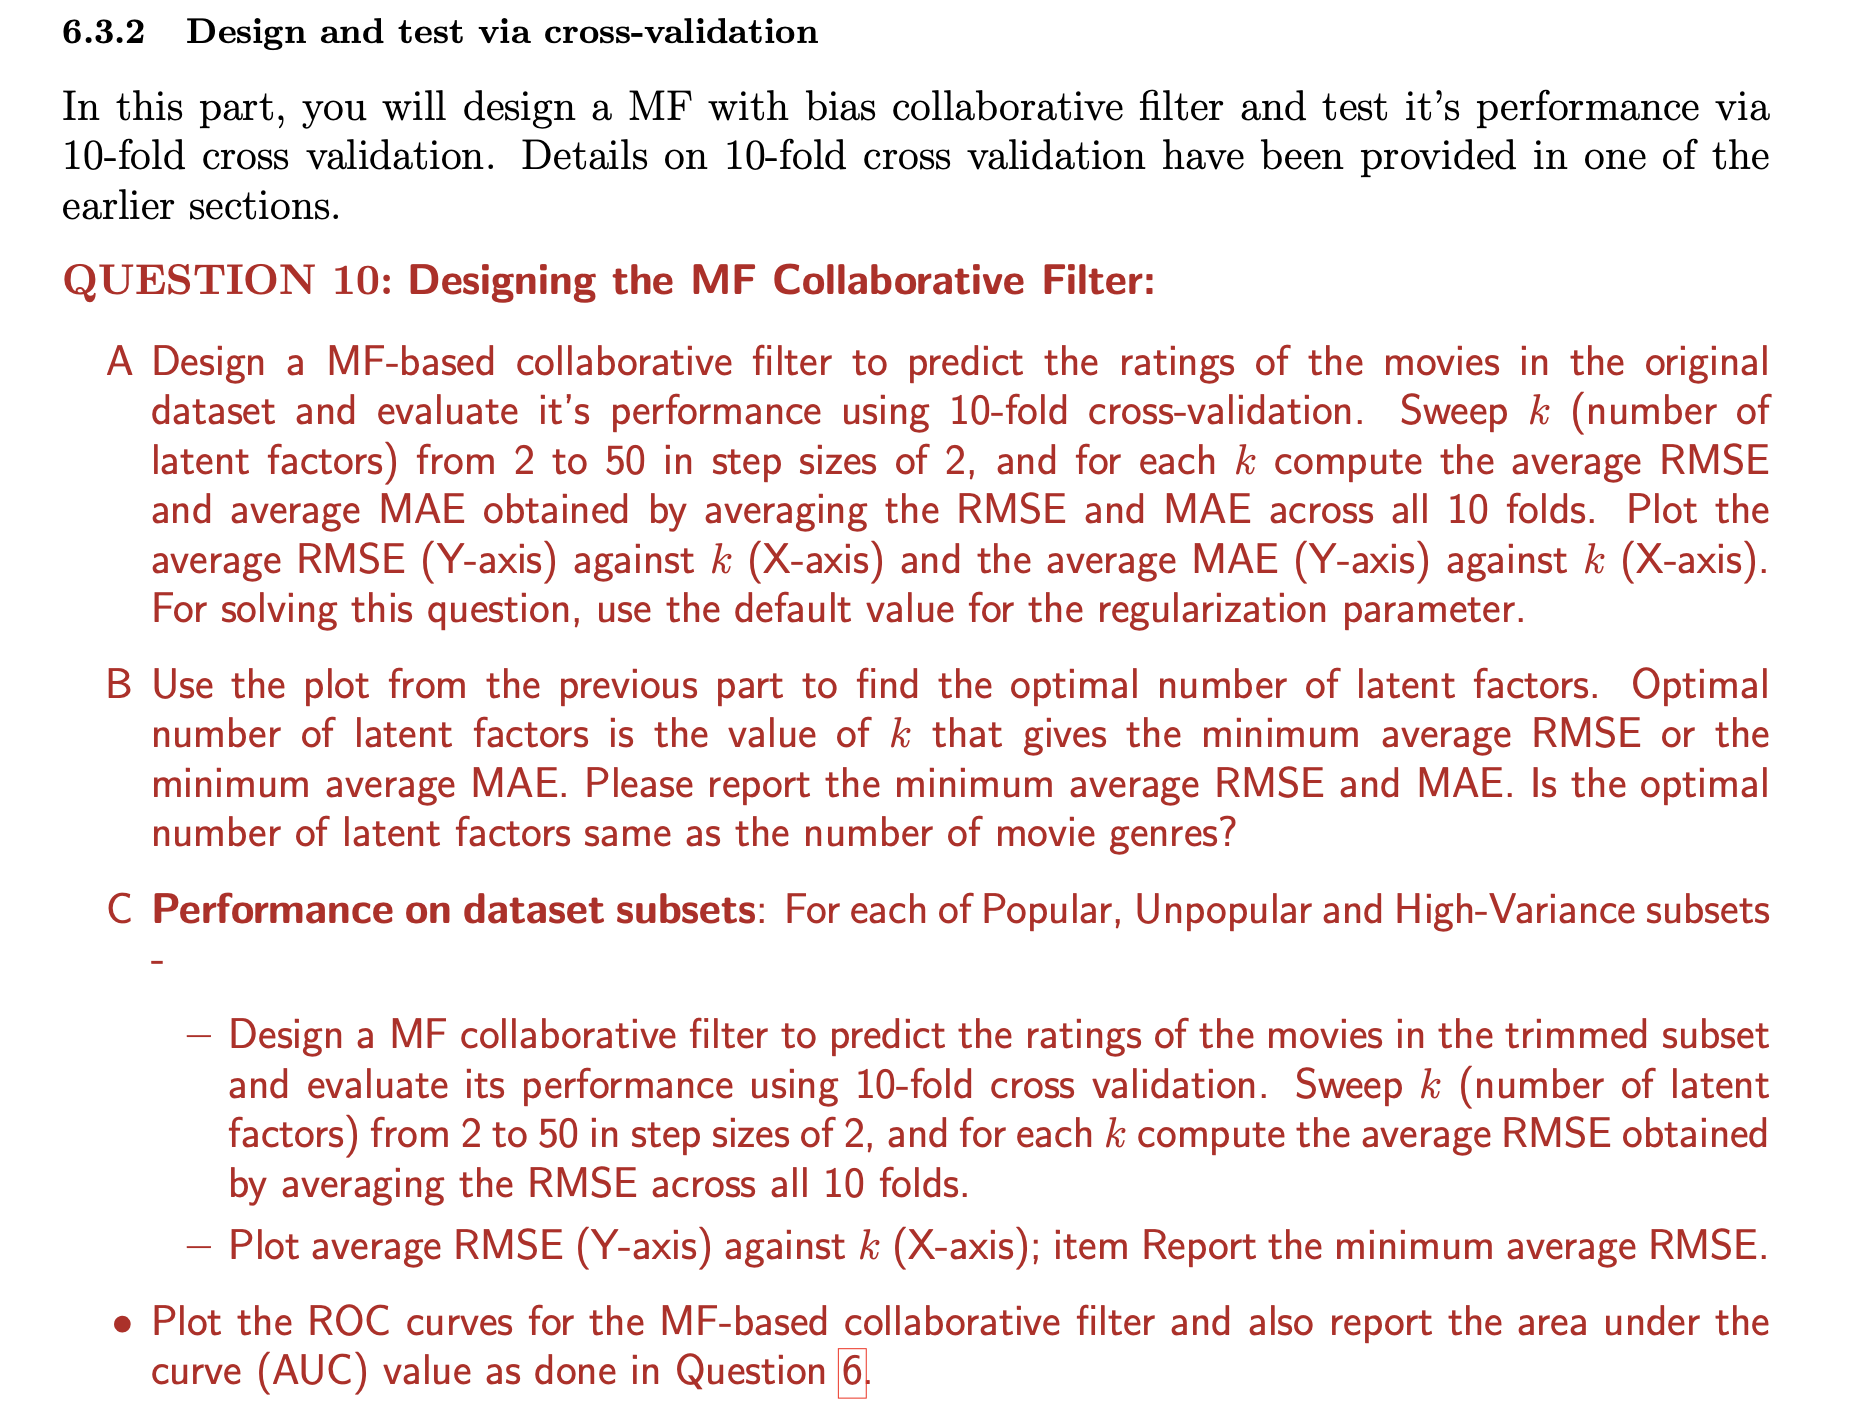

## MF Collaborative Filter

In [ ]:

from surprise.prediction_algorithms.matrix_factorization import SVD

# SVDs
svd_ks = np.arange(2,52,2)
svd_mae_baised, svd_rmse_biased = [],[]
for k in range(2,52,2):
    svd = SVD(n_factors=k, biased=True)
    cv = cross_validate(svd, data, measures=['RMSE','MAE'], cv=10, verbose=False)
    svd_rmse_biased.append(np.mean(cv['test_rmse']))
    print(len(svd_rmse_biased))
    svd_mae_baised.append(np.mean(cv['test_mae']))
    

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50


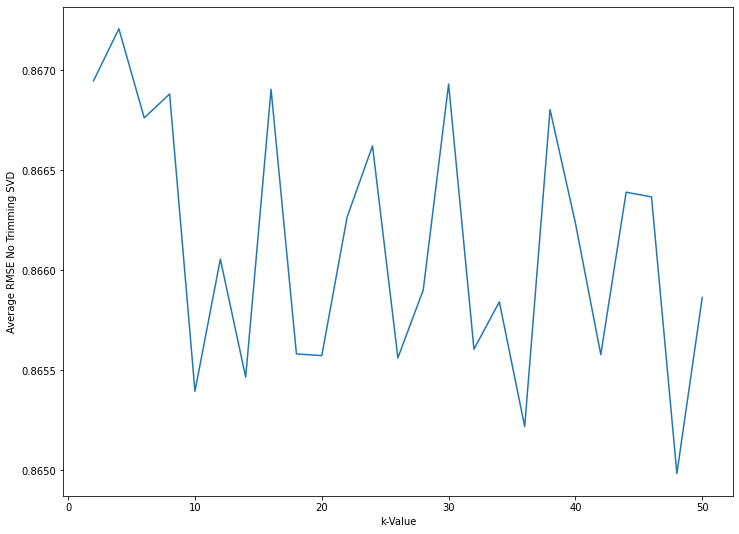

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
plt.plot(svd_ks, svd_rmse_biased)
ax.set_xlabel('k-Value')
ax.set_ylabel('Average RMSE No Trimming SVD')
ax.set_title('')
plt.show()

In [ ]:
print('Minimum Avg RMSE Value: ', np.min(svd_rmse_biased))

Minimum Avg RMSE Value:  0.8649819754100028


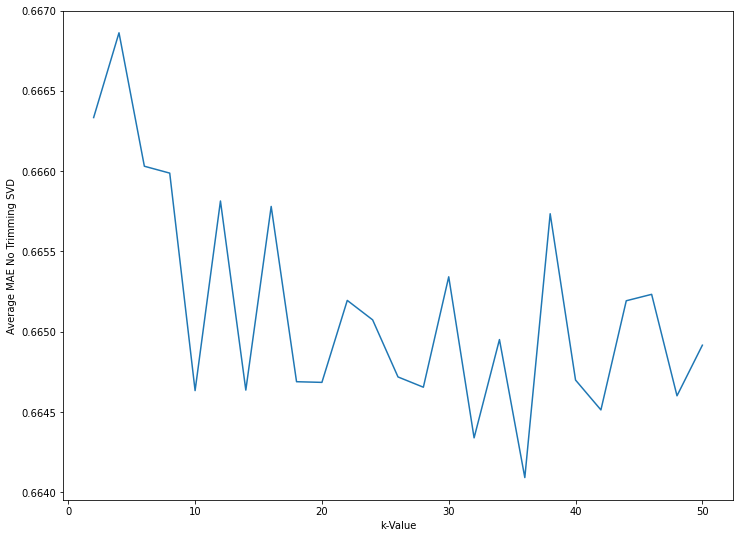

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
plt.plot(svd_ks, svd_mae_baised)
ax.set_xlabel('k-Value')
ax.set_ylabel('Average MAE No Trimming SVD')
ax.set_title('')
plt.show()

In [ ]:
print('Minimum Avg RMSE Value: ', np.min(svd_mae_baised))

Minimum Avg RMSE Value:  0.6640917791311313


In [ ]:
k_index = np.argmin(svd_rmse_biased)
min_k = k_index * 2
print("Minimum k:", min_k)
print("RMSE Value:", svd_rmse_biased[k])
print("MAE Value:", svd_mae_baised[k])

Minimum k: 46
RMSE Value: 0.8655805266022817
MAE Value: 0.6646888200744663


## Popular Trimmming RMSE MF

In [ ]:
from surprise import accuracy
from surprise.model_selection import KFold
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import Dataset
from surprise import Reader

reader = Reader(rating_scale=(.5, 5))
data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)

kf = KFold(n_splits=10)
RMSE_pop_trim_mf = []


for k in range(2,52,2):
  svd = SVD(n_factors=k, biased=True)
  temp_rmse = []
  for trainset, testset in kf.split(data):
    svd.fit(trainset)
    testset = popular_movie_trimming(testset, ratings)
    predictions = svd.test(testset)
    temp_rmse.append(accuracy.rmse(predictions, verbose=True))
  RMSE_pop_trim_mf.append(np.mean(temp_rmse))

RMSE: 0.8519
RMSE: 0.8696
RMSE: 0.8532
RMSE: 0.8618
RMSE: 0.8601
RMSE: 0.8598
RMSE: 0.8648
RMSE: 0.8543
RMSE: 0.8623
RMSE: 0.8562
RMSE: 0.8589
RMSE: 0.8574
RMSE: 0.8732
RMSE: 0.8596
RMSE: 0.8578
RMSE: 0.8466
RMSE: 0.8652
RMSE: 0.8514
RMSE: 0.8606
RMSE: 0.8594
RMSE: 0.8577
RMSE: 0.8654
RMSE: 0.8544
RMSE: 0.8546
RMSE: 0.8645
RMSE: 0.8606
RMSE: 0.8703
RMSE: 0.8589
RMSE: 0.8534
RMSE: 0.8557
RMSE: 0.8478
RMSE: 0.8613
RMSE: 0.8601
RMSE: 0.8614
RMSE: 0.8660
RMSE: 0.8625
RMSE: 0.8621
RMSE: 0.8598
RMSE: 0.8617
RMSE: 0.8537
RMSE: 0.8469
RMSE: 0.8662
RMSE: 0.8731
RMSE: 0.8423
RMSE: 0.8642
RMSE: 0.8613
RMSE: 0.8513
RMSE: 0.8631
RMSE: 0.8630
RMSE: 0.8559
RMSE: 0.8546
RMSE: 0.8651
RMSE: 0.8591
RMSE: 0.8598
RMSE: 0.8499
RMSE: 0.8682
RMSE: 0.8599
RMSE: 0.8537
RMSE: 0.8645
RMSE: 0.8551
RMSE: 0.8504
RMSE: 0.8707
RMSE: 0.8633
RMSE: 0.8630
RMSE: 0.8591
RMSE: 0.8507
RMSE: 0.8626
RMSE: 0.8598
RMSE: 0.8549
RMSE: 0.8581
RMSE: 0.8552
RMSE: 0.8646
RMSE: 0.8628
RMSE: 0.8627
RMSE: 0.8636
RMSE: 0.8473
RMSE: 0.8552

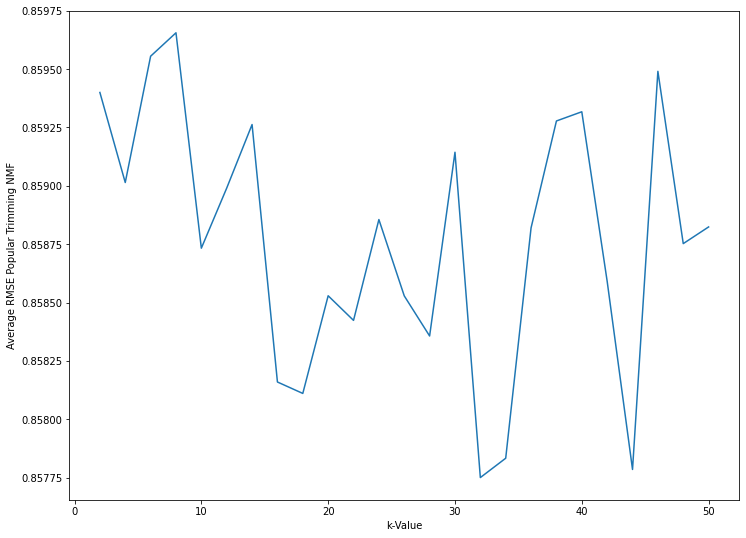

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
svd_ks = np.arange(2,52,2)
plt.plot(svd_ks, RMSE_pop_trim_mf)
ax.set_xlabel('k-Value')
ax.set_ylabel('Average RMSE Popular Trimming NMF')
ax.set_title('')
plt.show()

In [ ]:
print('Minimum Avg RMSE Value: ', np.min(RMSE_pop_trim_mf))

Minimum Avg RMSE Value:  0.8577500484830374


<Figure size 432x288 with 0 Axes>

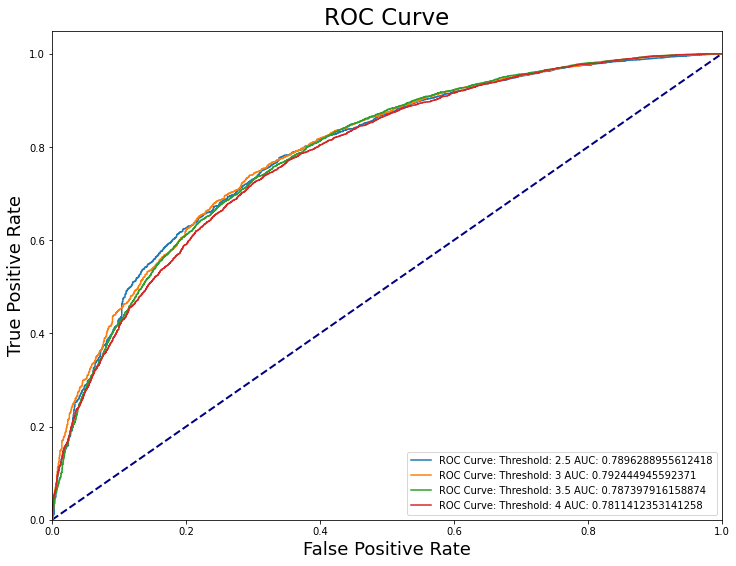

In [ ]:
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ratings_thresholds = [2.5,3,3.5,4]

fprs = []
tprs = []
AUCs = []

for threshold in ratings_thresholds:
    svd = SVD(n_factors=k, biased=True)
    trainset, testset = train_test_split(data, test_size=0.1)
    svd.fit(trainset)
    testset = popular_movie_trimming(testset, ratings)
    pred = svd.test(testset)
    
    real_y = []
    est_y = []
    for i in range(len(pred)):
        est_y.append(pred[i].est)
        if testset[i][2] >= threshold:
            real_y.append(1.0)
        else:
            real_y.append(0.0)
            
    fpr, tpr, thresholds = roc_curve(real_y, est_y)
    AUC = roc_auc_score(real_y, est_y)
    fprs.append(fpr)
    tprs.append(tpr)
    AUCs.append(AUC)

plt.gcf().clear()
plt.figure(figsize=(12,9))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve', fontsize=23)
for i in range(len(fprs)):
    plt.plot(fprs[i],tprs[i], label = 'ROC Curve: Threshold: {rt} AUC: {auc}'.format(rt=ratings_thresholds[i], auc=AUCs[i]) )
plt.legend(loc="lower right")
plt.show()

## Unpopular Trimming RMSE MF

In [ ]:
from surprise import accuracy
from surprise.model_selection import KFold
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import Dataset
from surprise import Reader

reader = Reader(rating_scale=(.5, 5))
data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)

kf = KFold(n_splits=10)
RMSE_unpop_trim_mf = []


for k in range(2,52,2):
  svd = SVD(n_factors=k, biased=True)
  temp_rmse = []
  for trainset, testset in kf.split(data):
    svd.fit(trainset)
    testset = unpopular_movie_trimming(testset, ratings)
    predictions = svd.test(testset)
    temp_rmse.append(accuracy.rmse(predictions, verbose=True))
  RMSE_unpop_trim_mf.append(np.mean(temp_rmse))

RMSE: 1.0355
RMSE: 0.9747
RMSE: 0.9362
RMSE: 0.9963
RMSE: 0.9735
RMSE: 1.0215
RMSE: 0.9955
RMSE: 0.9640
RMSE: 0.9562
RMSE: 0.9097
RMSE: 0.9819
RMSE: 0.9705
RMSE: 0.9570
RMSE: 0.9502
RMSE: 0.9739
RMSE: 1.0293
RMSE: 0.9784
RMSE: 0.9674
RMSE: 0.9559
RMSE: 0.9535
RMSE: 0.9714
RMSE: 0.9582
RMSE: 0.9794
RMSE: 1.0049
RMSE: 0.9976
RMSE: 1.0098
RMSE: 0.9500
RMSE: 0.9319
RMSE: 0.9509
RMSE: 0.9616
RMSE: 0.9594
RMSE: 0.9622
RMSE: 0.9978
RMSE: 0.9960
RMSE: 0.9859
RMSE: 0.9746
RMSE: 0.9357
RMSE: 0.9675
RMSE: 0.9112
RMSE: 1.0656
RMSE: 0.9701
RMSE: 0.9762
RMSE: 0.9193
RMSE: 0.9618
RMSE: 0.9876
RMSE: 0.9873
RMSE: 0.9522
RMSE: 0.9734
RMSE: 1.0004
RMSE: 0.9595
RMSE: 0.9520
RMSE: 0.9752
RMSE: 1.0012
RMSE: 0.9269
RMSE: 0.9792
RMSE: 0.9756
RMSE: 0.9836
RMSE: 1.0191
RMSE: 1.0054
RMSE: 0.9379
RMSE: 0.9991
RMSE: 0.9713
RMSE: 0.9949
RMSE: 0.9952
RMSE: 1.0464
RMSE: 0.9393
RMSE: 0.9216
RMSE: 0.9537
RMSE: 0.9291
RMSE: 1.0092
RMSE: 0.9640
RMSE: 1.0012
RMSE: 0.9671
RMSE: 0.9665
RMSE: 1.0375
RMSE: 0.9299
RMSE: 0.9496

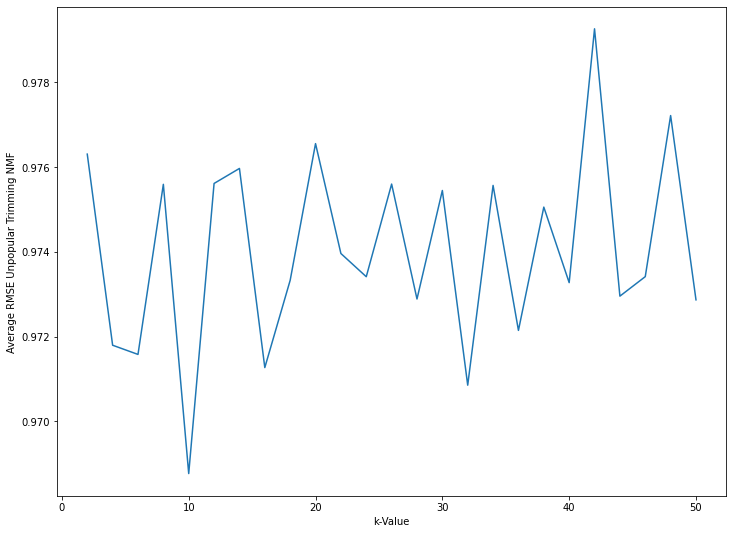

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
svd_ks = np.arange(2,52,2)
plt.plot(svd_ks, RMSE_unpop_trim_mf)
ax.set_xlabel('k-Value')
ax.set_ylabel('Average RMSE Unpopular Trimming NMF')
ax.set_title('')
plt.show()

In [ ]:
print('Minimum Avg RMSE Value: ', np.min(RMSE_unpop_trim_mf))

Minimum Avg RMSE Value:  0.9687701259508137


<Figure size 432x288 with 0 Axes>

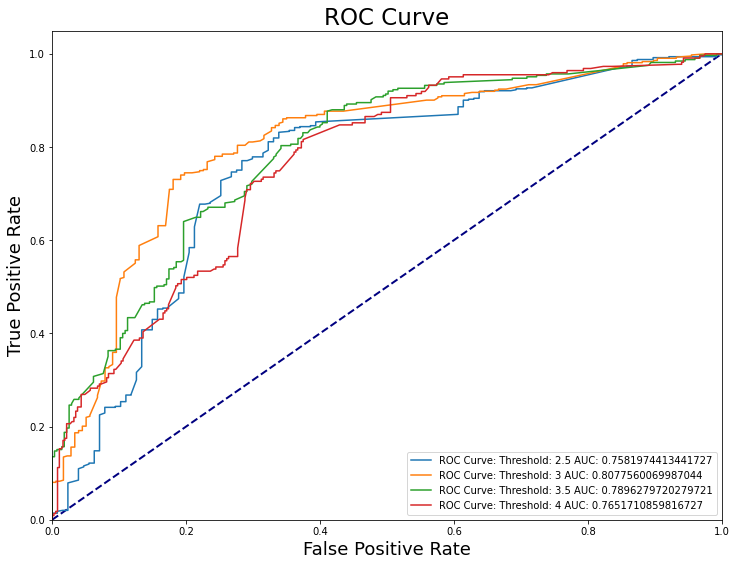

In [ ]:
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ratings_thresholds = [2.5,3,3.5,4]

fprs = []
tprs = []
AUCs = []

for threshold in ratings_thresholds:
    svd = SVD(n_factors=k, biased=True)
    trainset, testset = train_test_split(data, test_size=0.1)
    svd.fit(trainset)
    testset = unpopular_movie_trimming(testset, ratings)
    pred = svd.test(testset)
    
    real_y = []
    est_y = []
    for i in range(len(pred)):
        est_y.append(pred[i].est)
        if testset[i][2] >= threshold:
            real_y.append(1.0)
        else:
            real_y.append(0.0)
            
    fpr, tpr, thresholds = roc_curve(real_y, est_y)
    AUC = roc_auc_score(real_y, est_y)
    fprs.append(fpr)
    tprs.append(tpr)
    AUCs.append(AUC)

plt.gcf().clear()
plt.figure(figsize=(12,9))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve', fontsize=23)
for i in range(len(fprs)):
    plt.plot(fprs[i],tprs[i], label = 'ROC Curve: Threshold: {rt} AUC: {auc}'.format(rt=ratings_thresholds[i], auc=AUCs[i]) )
plt.legend(loc="lower right")
plt.show()

## High Variance Trimming

In [ ]:
from surprise import accuracy
from surprise.model_selection import KFold
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import Dataset
from surprise import Reader

reader = Reader(rating_scale=(.5, 5))
data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)

kf = KFold(n_splits=10)
RMSE_highvar_trim_mf = []


for k in range(2,52,2):
  svd = SVD(n_factors=k, biased=True)
  temp_rmse = []
  for trainset, testset in kf.split(data):
    svd.fit(trainset)
    testset = high_variance_trimming(testset, ratings)
    predictions = svd.test(testset)
    temp_rmse.append(accuracy.rmse(predictions, verbose=True))
  RMSE_highvar_trim_mf.append(np.mean(temp_rmse))

RMSE: 0.8340
RMSE: 0.7969
RMSE: 0.8366
RMSE: 0.8374
RMSE: 0.8269
RMSE: 0.8339
RMSE: 0.7973
RMSE: 0.8033
RMSE: 0.8260
RMSE: 0.8163
RMSE: 0.8306
RMSE: 0.8054
RMSE: 0.7999
RMSE: 0.7928
RMSE: 0.8348
RMSE: 0.8439
RMSE: 0.8286
RMSE: 0.8024
RMSE: 0.8403
RMSE: 0.8287
RMSE: 0.7995
RMSE: 0.8147
RMSE: 0.7962
RMSE: 0.8123
RMSE: 0.8217
RMSE: 0.8045
RMSE: 0.7972
RMSE: 0.8580
RMSE: 0.8411
RMSE: 0.8358
RMSE: 0.7747
RMSE: 0.8393
RMSE: 0.8520
RMSE: 0.8000
RMSE: 0.8093
RMSE: 0.7917
RMSE: 0.8306
RMSE: 0.8154
RMSE: 0.8071
RMSE: 0.8526
RMSE: 0.8335
RMSE: 0.8221
RMSE: 0.8501
RMSE: 0.7874
RMSE: 0.8098
RMSE: 0.8006
RMSE: 0.8320
RMSE: 0.8165
RMSE: 0.8058
RMSE: 0.8165
RMSE: 0.8213
RMSE: 0.8340
RMSE: 0.8558
RMSE: 0.8164
RMSE: 0.8224
RMSE: 0.7925
RMSE: 0.8131
RMSE: 0.8146
RMSE: 0.8078
RMSE: 0.8061
RMSE: 0.8327
RMSE: 0.8322
RMSE: 0.8026
RMSE: 0.7921
RMSE: 0.8066
RMSE: 0.8091
RMSE: 0.8311
RMSE: 0.7857
RMSE: 0.8389
RMSE: 0.8321
RMSE: 0.8035
RMSE: 0.8113
RMSE: 0.8247
RMSE: 0.7925
RMSE: 0.8311
RMSE: 0.8285
RMSE: 0.7962

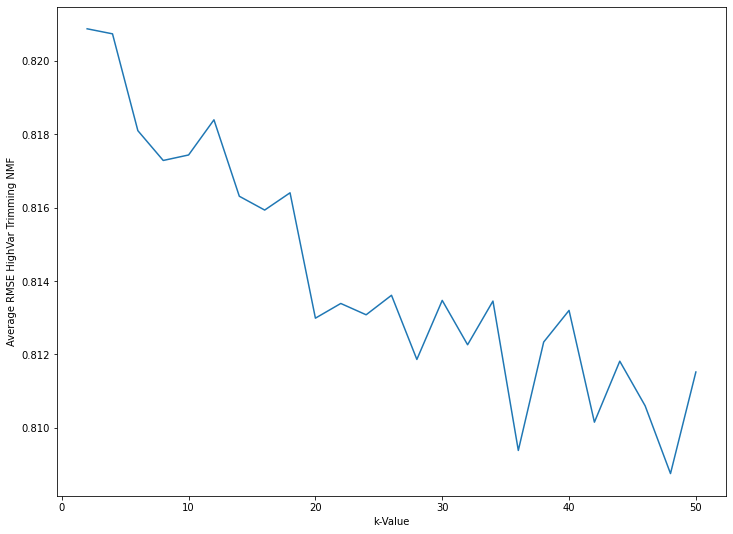

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
svd_ks = np.arange(2,52,2)
plt.plot(svd_ks, RMSE_highvar_trim_mf)
ax.set_xlabel('k-Value')
ax.set_ylabel('Average RMSE HighVar Trimming NMF')
ax.set_title('')
plt.show()

In [ ]:
print('Minimum Avg RMSE Value: ', np.min(RMSE_highvar_trim_mf))

Minimum Avg RMSE Value:  0.8087470277067016


<Figure size 432x288 with 0 Axes>

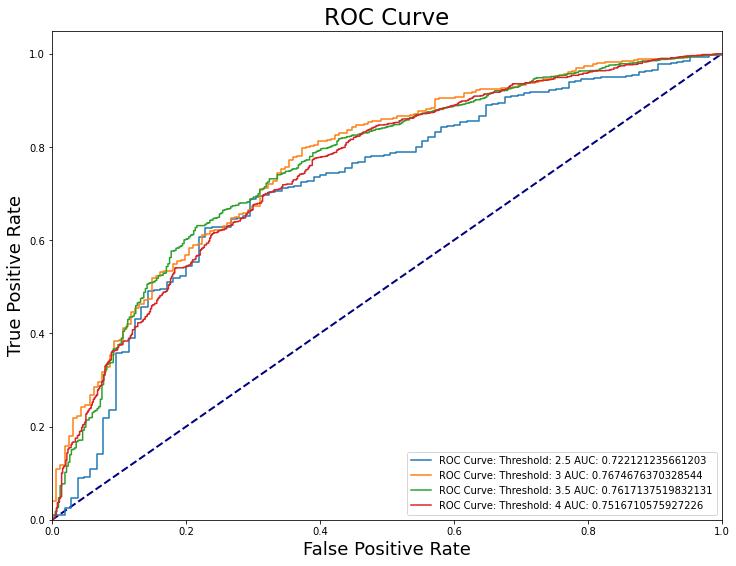

In [ ]:
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ratings_thresholds = [2.5,3,3.5,4]

fprs = []
tprs = []
AUCs = []

for threshold in ratings_thresholds:
    svd = SVD(n_factors=k, biased=True)
    trainset, testset = train_test_split(data, test_size=0.1)
    svd.fit(trainset)
    testset = high_variance_trimming(testset, ratings)
    pred = svd.test(testset)
    
    real_y = []
    est_y = []
    for i in range(len(pred)):
        est_y.append(pred[i].est)
        if testset[i][2] >= threshold:
            real_y.append(1.0)
        else:
            real_y.append(0.0)
            
    fpr, tpr, thresholds = roc_curve(real_y, est_y)
    AUC = roc_auc_score(real_y, est_y)
    fprs.append(fpr)
    tprs.append(tpr)
    AUCs.append(AUC)

plt.gcf().clear()
plt.figure(figsize=(12,9))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve', fontsize=23)
for i in range(len(fprs)):
    plt.plot(fprs[i],tprs[i], label = 'ROC Curve: Threshold: {rt} AUC: {auc}'.format(rt=ratings_thresholds[i], auc=AUCs[i]) )
plt.legend(loc="lower right")
plt.show()

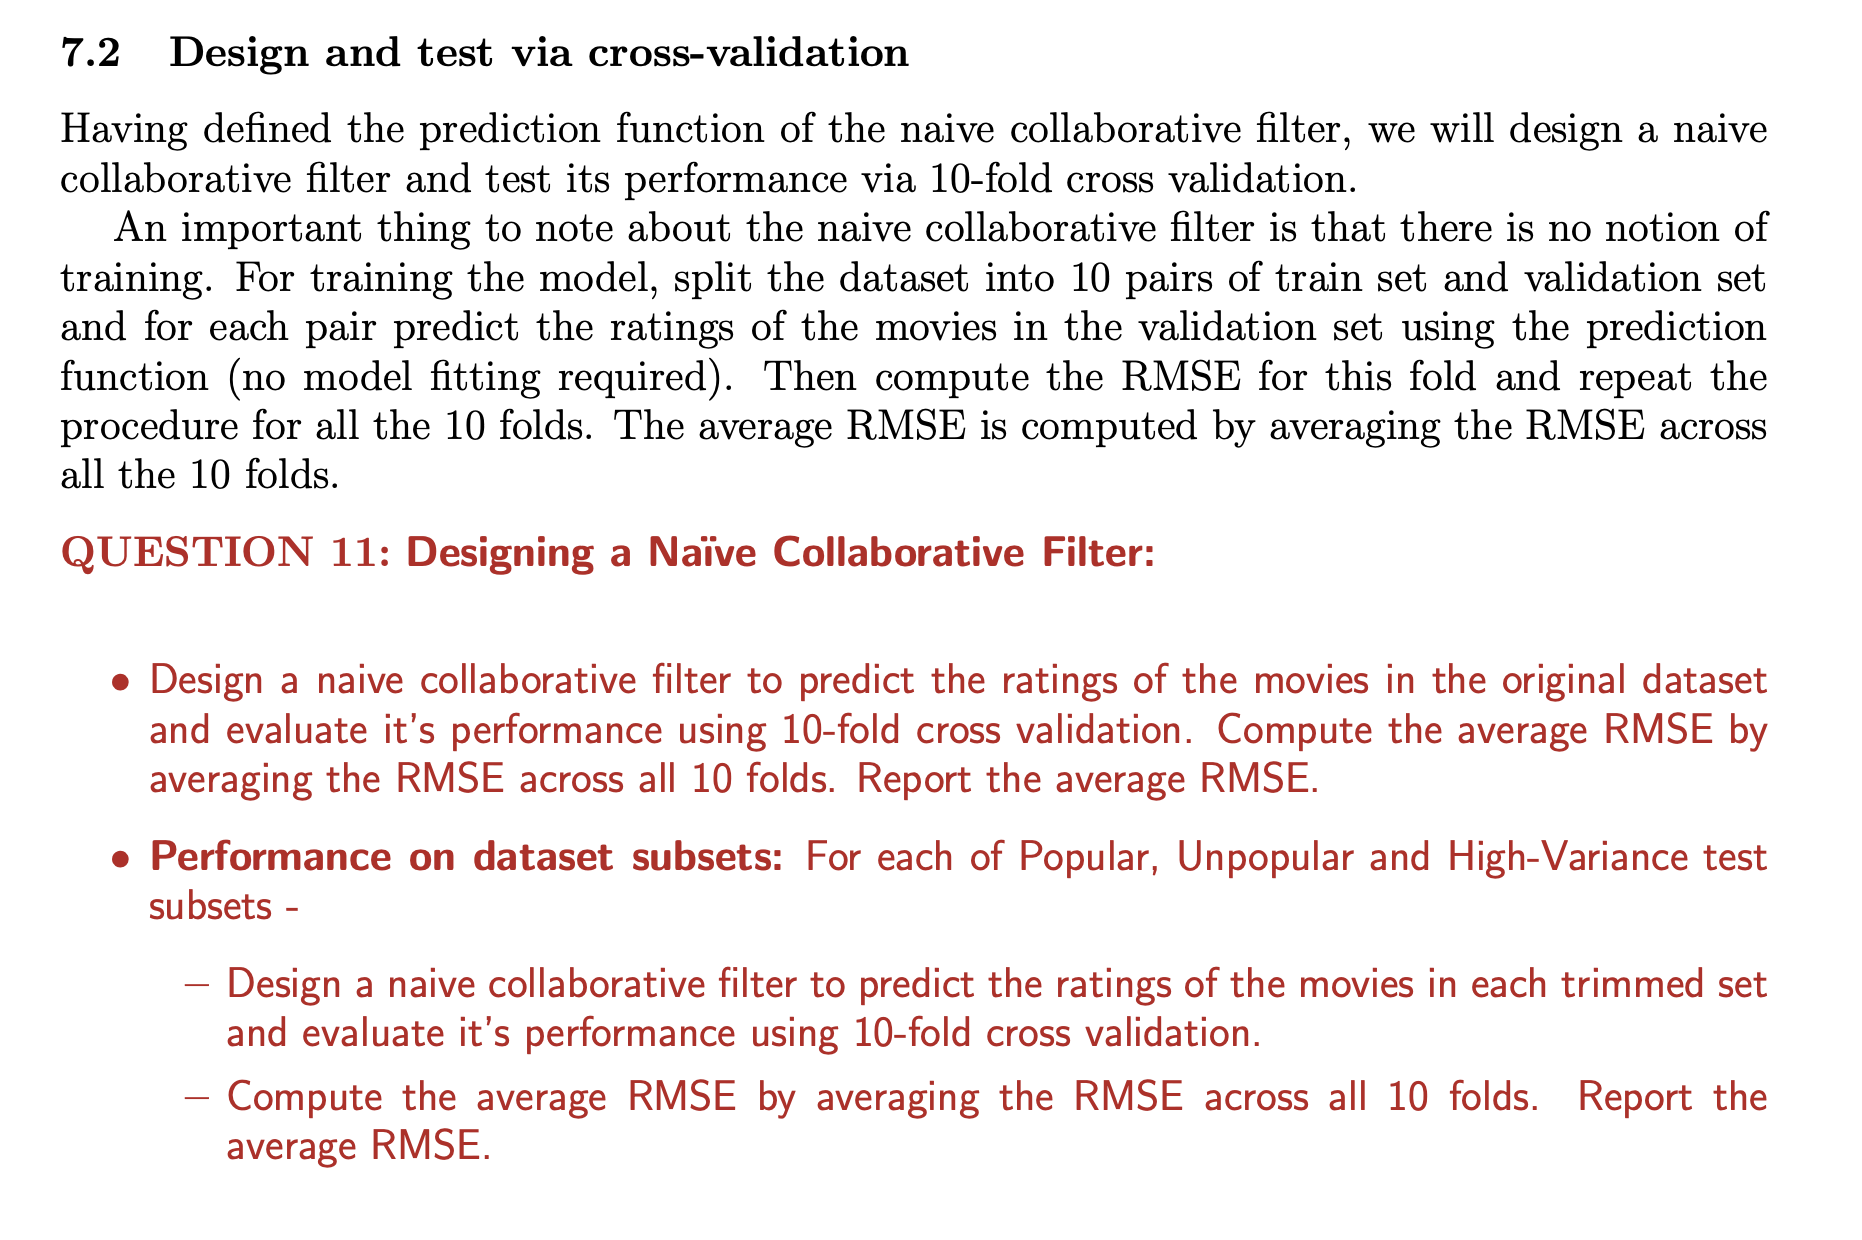

## Naive Bayes Collaborative Filtering

In [ ]:
from sklearn.metrics import mean_squared_error

user_ratings_dict = {}
for i in data.raw_ratings:
    if i[0] in user_ratings_dict.keys():
        user_ratings_dict[i[0]].append(i[2])
    else:
        user_ratings_dict[i[0]] = []
        user_ratings_dict[i[0]].append(i[2])

truth_mean = {}
for j in user_ratings_dict.keys():
    truth_mean[j] = np.mean(user_ratings_dict[j])

rmse = 0
kf = KFold(n_splits=10)
for trainset, testset in kf.split(data):
    pred = [truth_mean[i[0]] for i in testset]
    true = [i[2] for i in testset]
    rmse += np.sqrt(mean_squared_error(true,pred))
avg_rmse = rmse/10.0

print("Average RMSE for naive collaborative filter: ", avg_rmse)

Average RMSE for naive collaborative filter:  0.9346977038461164


## Popular Trimming Naive Collaborative Filter

In [ ]:
from sklearn.metrics import mean_squared_error

rmse = 0
kf = KFold(n_splits=10)
for trainset, testset in kf.split(data):
    testset = popular_movie_trimming(testset, ratings)
    pred = [truth_mean[i[0]] for i in testset]
    true = [i[2] for i in testset]
    rmse += np.sqrt(mean_squared_error(true,pred))
avg_rmse = rmse/10.0

print("Average RMSE for naive collaborative filter: ", avg_rmse)

Average RMSE for naive collaborative filter:  0.9323140600196791


## Unpopular Trimming Naive Collaborative Filter

In [ ]:
from sklearn.metrics import mean_squared_error

rmse = 0
kf = KFold(n_splits=10)
for trainset, testset in kf.split(data):
    testset = unpopular_movie_trimming(testset, ratings)
    pred = [truth_mean[i[0]] for i in testset]
    true = [i[2] for i in testset]
    rmse += np.sqrt(mean_squared_error(true,pred))
avg_rmse = rmse/10.0

print("Average RMSE for naive collaborative filter: ", avg_rmse)

Average RMSE for naive collaborative filter:  0.9709138842749914


## High Var Trimming

In [ ]:
from sklearn.metrics import mean_squared_error

rmse = 0
kf = KFold(n_splits=10)
for trainset, testset in kf.split(data):
    testset = high_variance_trimming(testset, ratings)
    pred = [truth_mean[i[0]] for i in testset]
    true = [i[2] for i in testset]
    rmse += np.sqrt(mean_squared_error(true,pred))
avg_rmse = rmse/10.0

print("Average RMSE for naive collaborative filter: ", avg_rmse)

Average RMSE for naive collaborative filter:  0.9199335580141842


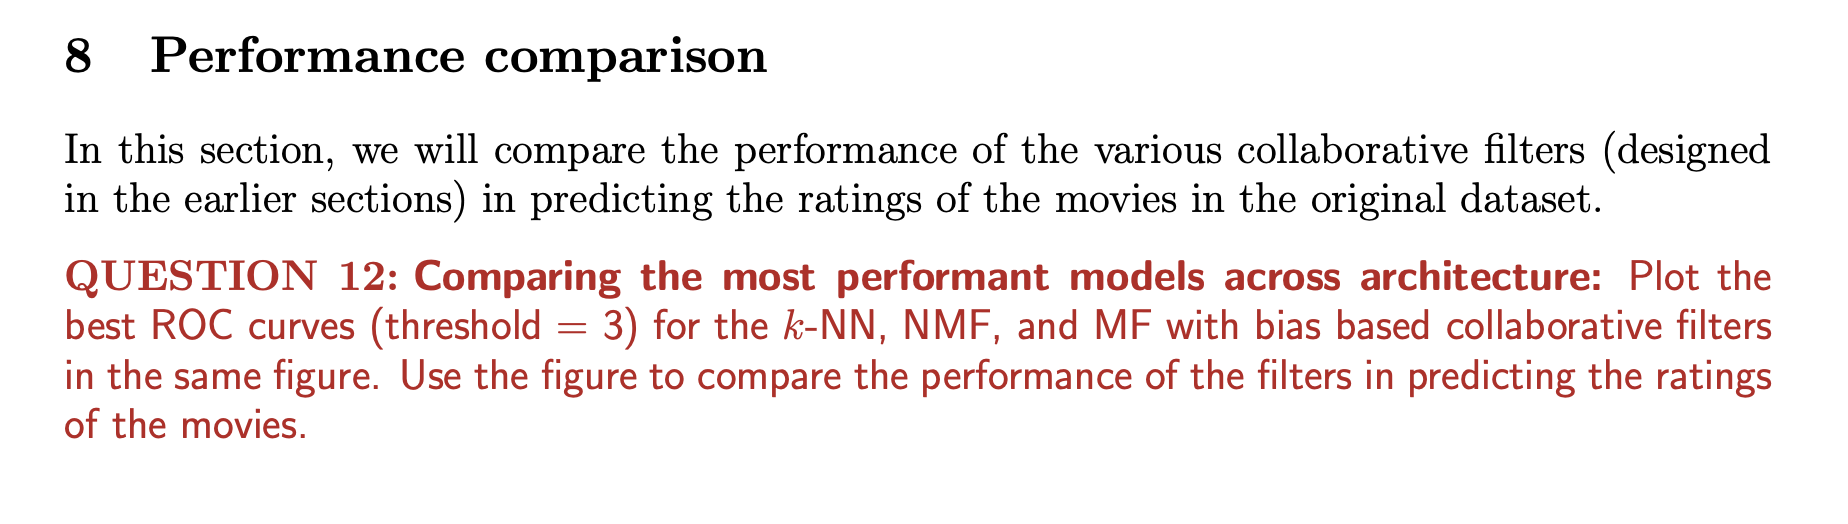

Computing the pearson similarity matrix...
Done computing similarity matrix.


<Figure size 432x288 with 0 Axes>

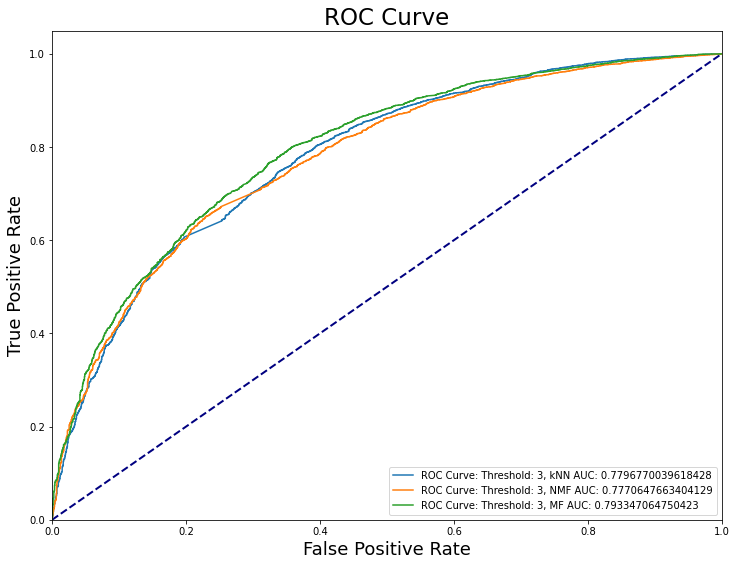

In [ ]:
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import KNNWithMeans
from surprise.prediction_algorithms import NMF
from surprise.prediction_algorithms import SVD
from surprise import Dataset
from surprise import Reader
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

threshold = 3

compare_fprs = []
compare_tprs = []
compare_AUCs = []

reader = Reader(rating_scale=(.5, 5))

data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.1)

#knn
knn = KNNWithMeans(k=26, sim_options={'name': 'pearson'})
knn.fit(trainset)
knn_pred = knn.test(testset)

    
real_y = []
est_y = []
for i in range(len(knn_pred)):
    est_y.append(knn_pred[i].est)
    if testset[i][2] >= threshold: #ratings threshold
        real_y.append(1.0)
    else:
        real_y.append(0.0)
            
fpr, tpr, thresholds = roc_curve(real_y, est_y)
AUC = roc_auc_score(real_y, est_y)
compare_fprs.append(fpr)
compare_tprs.append(tpr)
compare_AUCs.append(AUC)

#NMF baised = False
nmf = NMF(n_factors=26, biased=False)
nmf.fit(trainset)
nmf_pred = nmf.test(testset)

real_y = []
est_y = []
for i in range(len(nmf_pred)):
    est_y.append(nmf_pred[i].est)
    if testset[i][2] >= threshold: #ratings threshold
        real_y.append(1.0)
    else:
        real_y.append(0.0)
        
fpr, tpr, thresholds = roc_curve(real_y, est_y)
AUC = roc_auc_score(real_y, est_y)
compare_fprs.append(fpr)
compare_tprs.append(tpr)
compare_AUCs.append(AUC)


#NMF baised = true
nmf_biased = SVD(n_factors=46, biased=True)
nmf_biased.fit(trainset)
nmf_biased_pred = nmf_biased.test(testset)

real_y = []
est_y = []
for i in range(len(nmf_biased_pred)):
    est_y.append(nmf_biased_pred[i].est)
    if testset[i][2] >= threshold: #ratings threshold
        real_y.append(1.0)
    else:
        real_y.append(0.0)

fpr, tpr, thresholds = roc_curve(real_y, est_y)
AUC = roc_auc_score(real_y, est_y)
compare_fprs.append(fpr)
compare_tprs.append(tpr)
compare_AUCs.append(AUC)

ratings_thresholds = ['3, kNN', '3, NMF', '3, MF']
plt.gcf().clear()
plt.figure(figsize=(12,9))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve', fontsize=23)
for i in range(len(compare_fprs)):
    plt.plot(compare_fprs[i],compare_tprs[i], label = 'ROC Curve: Threshold: {rt} AUC: {auc}'.format(rt=ratings_thresholds[i], auc=compare_AUCs[i]) )
plt.legend(loc="lower right")
plt.show()

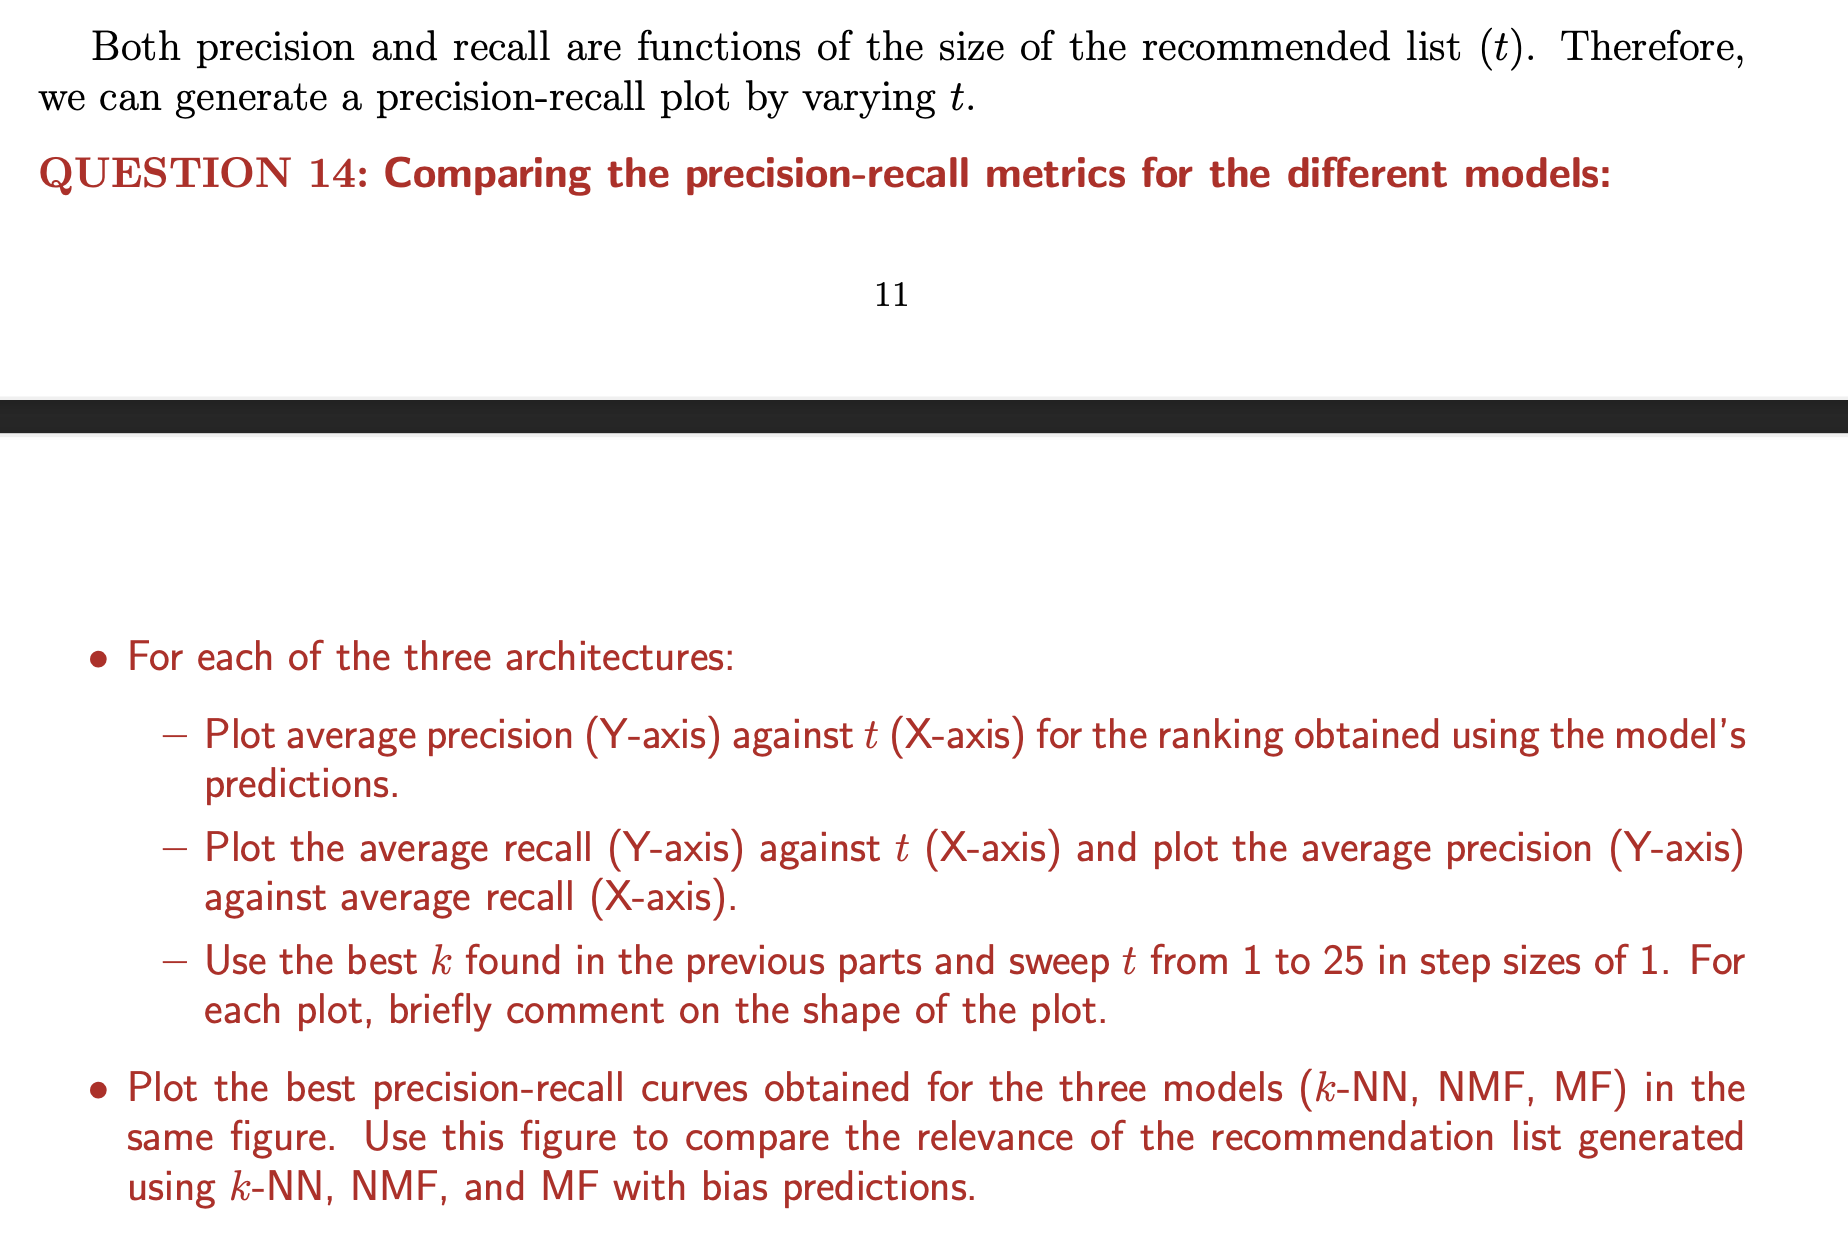

In [ ]:
from collections import defaultdict

def calc_prec_recall(pred, t, threshold=3):
    user_truth = defaultdict(list)
    for u, _, tr, e, _ in pred:
        user_truth[u].append((e, tr))

    precisions = {}
    recalls = {}
    for id, ur in user_truth.items():
        ur.sort(key=lambda x: x[0], reverse=True)
        
        nrec = t
        
        n_rel_and_rec_k = 0
        for i in range(t):
            if ur[i][1] >= threshold:
                n_rel_and_rec_k += 1
        
        n_rel = sum((true_r >= threshold) for (_, true_r) in ur)

        precisions[id] = n_rel_and_rec_k / nrec

        recalls[id] = n_rel_and_rec_k / n_rel

    return precisions, recalls

In [ ]:
def test_trim(testset, t, threshold=3):
    count = {}
    likes = {}
    
    for (u, i, r) in testset:
        if u not in count:
            count[u] = 0
        count[u] += 1
        if u not in likes:
            likes[u] = 0
        if r >= threshold:
            likes[u] += 1
            
    res = []
    for (u, i, r) in testset:
        if count[u] >= t and likes[u] > 0:
            res.append((u, i, r))
    
    return res

In [ ]:

from surprise.prediction_algorithms import KNNWithMeans
from surprise.model_selection import KFold

threshold = 3
ts = [i for i in range(1, 25 + 1)]

knn_precision = []
knn_recall = []
kf = KFold(n_splits=10)

for t in ts:
    temp_prec = []
    temp_recall = []

    for trainset, testset in kf.split(data):
        knn = KNNWithMeans(k=20, sim_options={'name': 'pearson'})
        knn.fit(trainset)
        trimmed_testset = test_trim(testset, t)
        pred = knn.test(trimmed_testset)
    
        precisions, recalls = calc_prec_recall(pred, t)
        fold_mean_prec = sum(prec for prec in precisions.values()) / len(precisions)
        fold_mean_recall = sum(rec for rec in recalls.values()) / len(recalls)
            
        temp_prec.append(fold_mean_prec)
        temp_recall.append(fold_mean_recall)
    
    t_mean_prec = sum(prec for prec in temp_prec) / len(temp_prec)
    t_mean_recall = sum(rec for rec in temp_recall) / len(temp_recall)
    knn_precision.append(t_mean_prec)
    knn_recall.append(t_mean_recall)    

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

<Figure size 432x288 with 0 Axes>

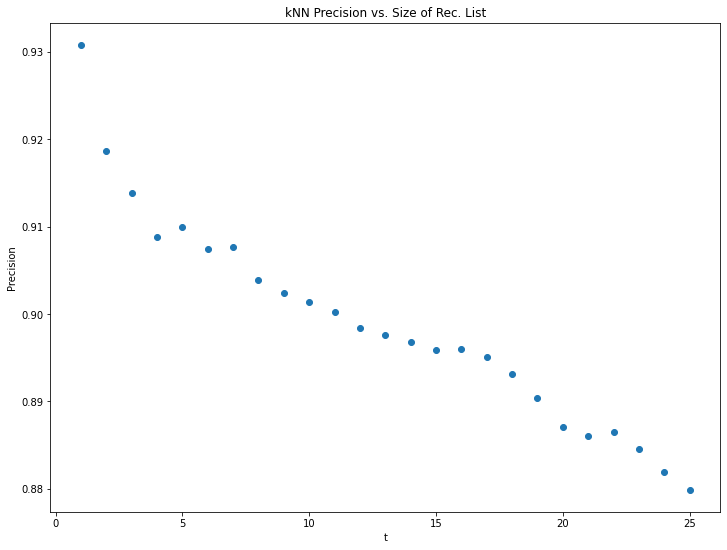

In [ ]:
plt.gcf().clear()
plt.figure(figsize=(12,9))
plt.scatter(ts, knn_precision)
plt.xlabel('t')
plt.ylabel('Precision')
plt.title('kNN Precision vs. Size of Rec. List')
plt.show()

<Figure size 432x288 with 0 Axes>

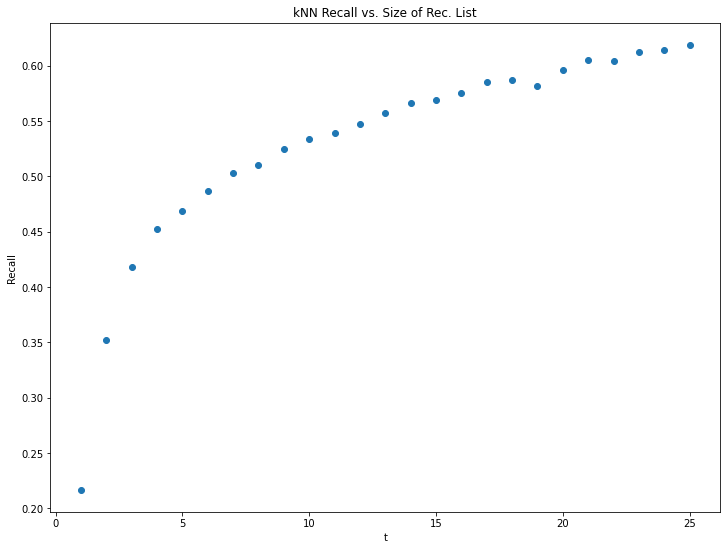

In [ ]:
plt.gcf().clear()
plt.figure(figsize=(12,9))
plt.scatter(ts, knn_recall)
plt.xlabel('t')
plt.ylabel('Recall')
plt.title('kNN Recall vs. Size of Rec. List')
plt.show()

<Figure size 432x288 with 0 Axes>

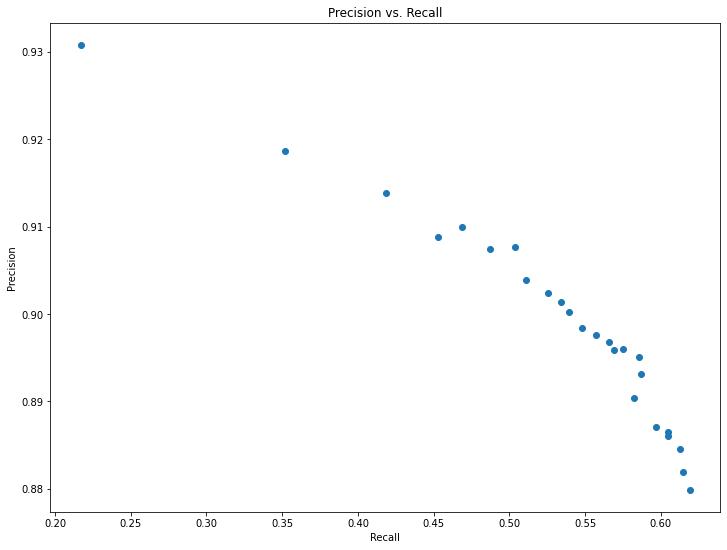

In [ ]:
plt.gcf().clear()
plt.figure(figsize=(12,9))
plt.scatter(knn_recall, knn_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall')
plt.show()

In [ ]:
nmf_precision = []
nmf_recall = []

for t in ts:
    temp_prec = []
    temp_recall = []

    for trainset, testset in kf.split(data):
        nmf = NMF(n_factors=26, biased=False)
        nmf.fit(trainset)
        trimmed_testset = test_trim(testset, t)
        pred = nmf.test(trimmed_testset)
    
        precisions, recalls = calc_prec_recall(pred, t)
        fold_mean_prec = sum(prec for prec in precisions.values()) / len(precisions)
        fold_mean_recall = sum(rec for rec in recalls.values()) / len(recalls)
            
        temp_prec.append(fold_mean_prec)
        temp_recall.append(fold_mean_recall)
    
    t_mean_prec = sum(prec for prec in temp_prec) / len(temp_prec)
    t_mean_recall = sum(rec for rec in temp_recall) / len(temp_recall)
    nmf_precision.append(t_mean_prec)
    nmf_recall.append(t_mean_recall)

<Figure size 432x288 with 0 Axes>

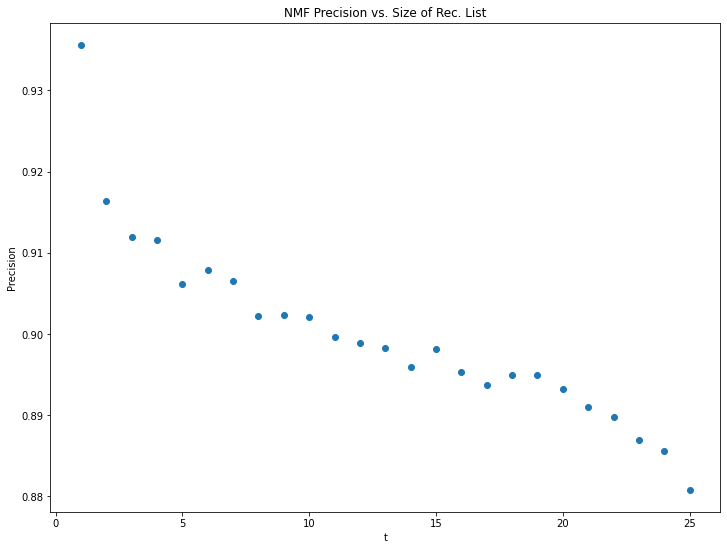

In [ ]:
plt.gcf().clear()
plt.figure(figsize=(12,9))
plt.scatter(ts, nmf_precision)
plt.xlabel('t')
plt.ylabel('Precision')
plt.title('NMF Precision vs. Size of Rec. List')
plt.show()

<Figure size 432x288 with 0 Axes>

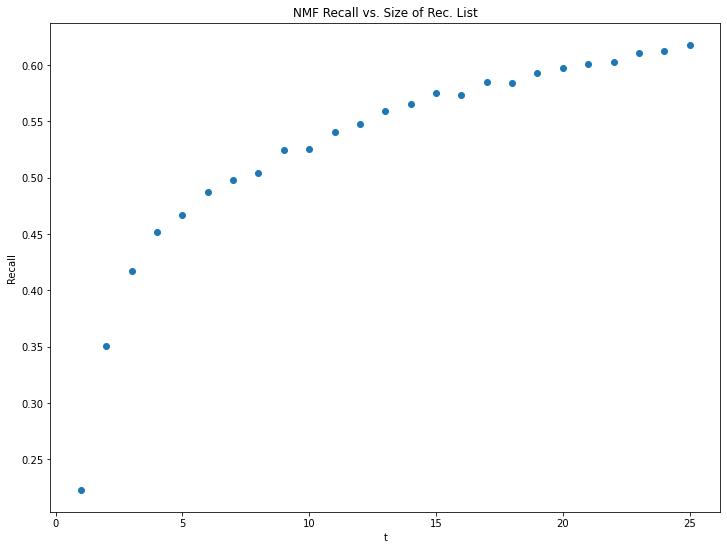

In [ ]:
plt.gcf().clear()
plt.figure(figsize=(12,9))
plt.scatter(ts, nmf_recall)
plt.xlabel('t')
plt.ylabel('Recall')
plt.title('NMF Recall vs. Size of Rec. List')
plt.show()

<Figure size 432x288 with 0 Axes>

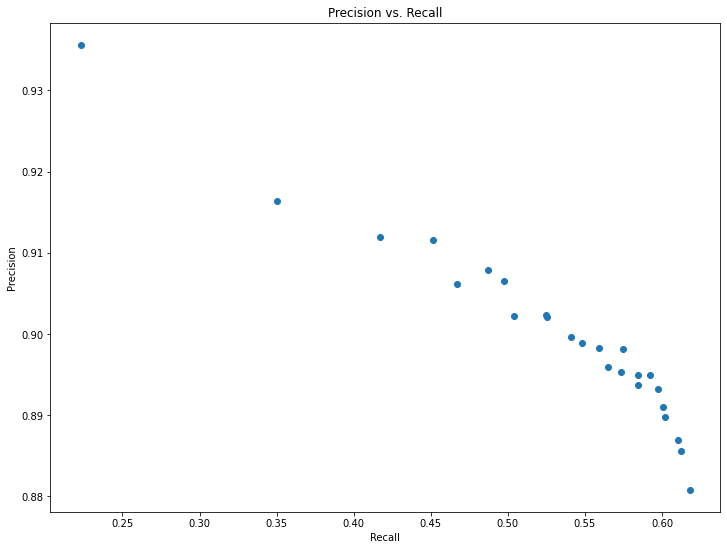

In [ ]:
plt.gcf().clear()
plt.figure(figsize=(12,9))
plt.scatter(nmf_recall, nmf_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall')
plt.show()

In [ ]:
from surprise.prediction_algorithms import SVD

svd_biased_precision = []
svd_biased_recall = []

for t in ts:
    temp_prec = []
    temp_recall = []

    for trainset, testset in kf.split(data):
        svd = SVD(n_factors=16, biased=True)
        svd.fit(trainset)
        trimmed_testset = test_trim(testset, t)
        pred = nmf.test(trimmed_testset)
    
        precisions, recalls = calc_prec_recall(pred, t)
        fold_mean_prec = sum(prec for prec in precisions.values()) / len(precisions)
        fold_mean_recall = sum(rec for rec in recalls.values()) / len(recalls)
            
        temp_prec.append(fold_mean_prec)
        temp_recall.append(fold_mean_recall)
    
    t_mean_prec = sum(prec for prec in temp_prec) / len(temp_prec)
    t_mean_recall = sum(rec for rec in temp_recall) / len(temp_recall)
    svd_biased_precision.append(t_mean_prec)
    svd_biased_recall.append(t_mean_recall)

<Figure size 432x288 with 0 Axes>

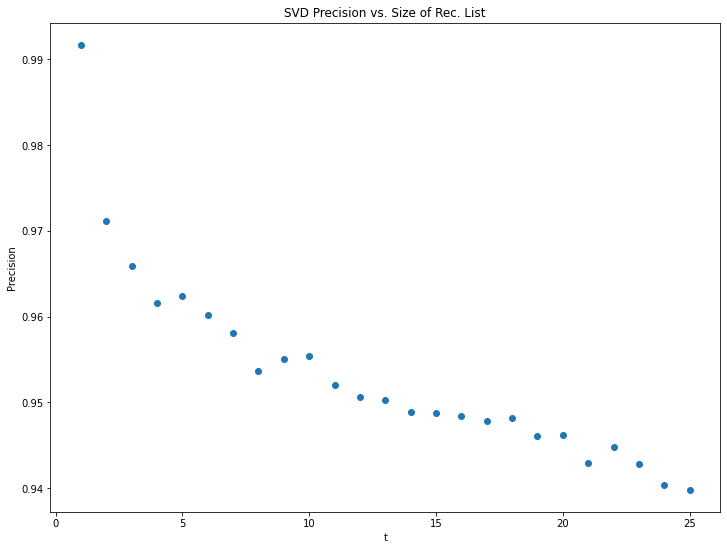

In [ ]:
plt.gcf().clear()
plt.figure(figsize=(12,9))
plt.scatter(ts, svd_biased_precision)
plt.xlabel('t')
plt.ylabel('Precision')
plt.title('SVD Precision vs. Size of Rec. List')
plt.show()

<Figure size 432x288 with 0 Axes>

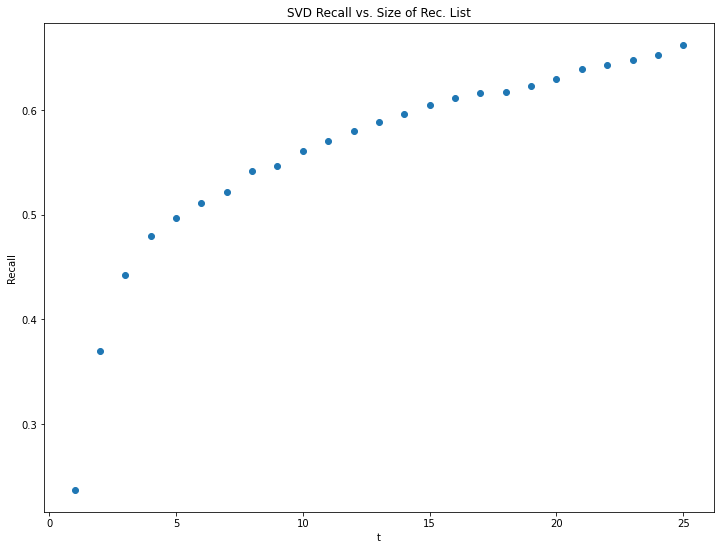

In [ ]:
plt.gcf().clear()
plt.figure(figsize=(12,9))
plt.scatter(ts, svd_biased_recall)
plt.xlabel('t')
plt.ylabel('Recall')
plt.title('SVD Recall vs. Size of Rec. List')
plt.show()

<Figure size 432x288 with 0 Axes>

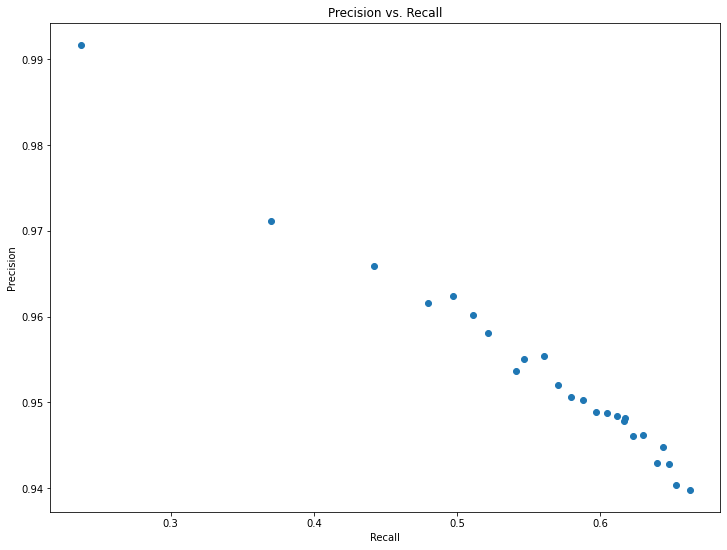

In [ ]:
plt.gcf().clear()
plt.figure(figsize=(12,9))
plt.scatter(svd_biased_recall, svd_biased_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall')
plt.show()

<Figure size 432x288 with 0 Axes>

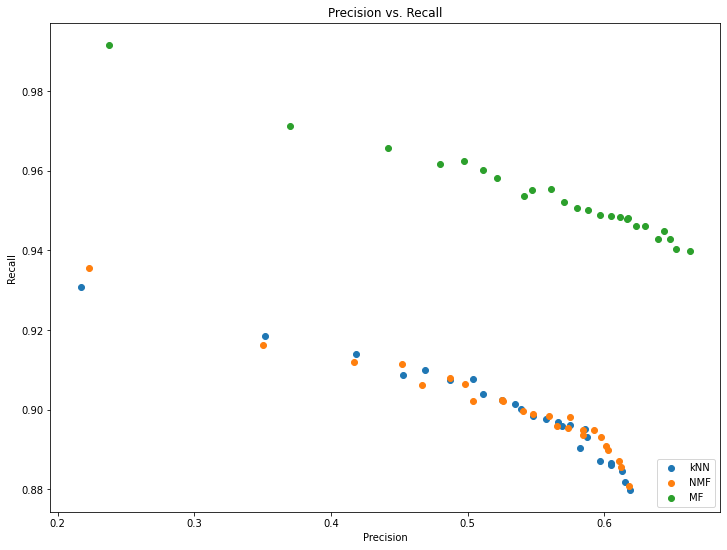

In [ ]:
plt.gcf().clear()
plt.figure(figsize=(12, 9))
plt.scatter(knn_recall,knn_precision, label='kNN')
plt.scatter(nmf_recall,nmf_precision, label='NMF')
plt.scatter(svd_biased_recall,svd_biased_precision, label='MF')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision vs. Recall')
plt.legend(loc="lower right")
plt.show()